# Distributed Asynchronous Hyper-parameter Optimization with NGBoost

## Notes on Hyperopt

Hyperopt will allow us to intelligently narrow our search space over traditional methods like grid search in sklearn and thus save runtime when tuning our NGBoost model.

Original Article:

*Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. To appear in Proc. of the 30th International Conference on Machine Learning (ICML 2013).*

For install instructions and more information on how Hyperopt works click [here](http://hyperopt.github.io/hyperopt/)


## Import Dependencies

In [102]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from hyperopt import hp, tpe, space_eval
from hyperopt.pyll.base import scope
from hyperopt.fmin import fmin
from hyperopt import STATUS_OK, Trials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging

## Setup basic logging

In [103]:
logging.basicConfig(
    # filename = "errors.log",
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger()

## Load the Boston Housing Dataset

For this example we will be splitting the dataset into train/test/validation sets

In [104]:
boston = load_boston()
data = boston.data
target = boston.target

X_intermediate, X_test, y_intermediate, y_test = train_test_split(data, 
                                                                  target, 
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=1)

# train/validation split (gives us train and validation sets)
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=1)

# delete intermediate variables
del X_intermediate, y_intermediate

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(target),2),
                                                       round(len(y_validation)/len(target),2),
                                                       round(len(y_test)/len(target),2)))

train: 0.6% | validation: 0.2% | test 0.2%


## Setup the Hyper-Parameters to test

Note:
- hp.choice selects from the provided list
- hp.uniform will iterate at random over the range provided like .05 to 1

In [105]:
b1 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=2)
b2 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3)
b3 = DecisionTreeRegressor(criterion='friedman_mse', max_depth=4)

space = {
    'learning_rate':hp.uniform('learning_rate', .05, 1),
    'minibatch_frac':hp.choice('minibatch_frac', [1.0, 0.5]),
    'Base':hp.choice('Base', [b1, b2, b3])
}

default_params = {"n_estimators":20,
                  "verbose_eval":1,
                  "random_state":1}

## Setup the model to be tested and log the loss for each test

Note: This example uses early stopping

This objective will log the loss of the best iteration among each pass (n_estimators) using best_val_loss_itr from the NGBRegressor object

In [106]:
def objective(params):
    
    params.update(default_params)
    
    print(params)
    ngb = NGBRegressor(**params).fit(X_train,y_train,X_val=X_validation, Y_val=y_validation, early_stopping_rounds=2)
    loss = ngb.evals_result['val']['LOGSCORE'][ngb.best_val_loss_itr]
    logger.info(params)
    results = {'loss':loss, 'status':STATUS_OK}
    
    return results

## Run tuning

We can modify max_evals here to adjust how many differnt sets of hyper-parameters we want to test

In [107]:
TRIALS = Trials()
logger.info("Start parameter optimization...")


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=100,
                trials=TRIALS)
logger.info("...done")

2020-07-15 09:27:19 INFO     Start parameter optimization...


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001168 seconds
2020-07-15 09:27:19 INFO     TPE using 0 trials


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5941063569670545, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3655 scale=0.5000 norm=3.2975
[iter 1] loss=3.3340 val_loss=3.1571 scale=1.0000 norm=5.2266
[iter 2] loss=3.0992 val_loss=2.8915 scale=2.0000 norm=7.6599
[iter 3] loss=2.7901 val_loss=2.8704 scale=2.0000 norm=5.7775
[iter 4] loss=2.6825 val_loss=2.8907 scale=1.0000 norm=2.7723
[iter 5] loss=2.5984 val_loss=2.8398 scale=1.0000 norm=2.6167
[iter 6] loss=2.5280 val_loss=2.8934 scale=1.0000 norm=2.5098
== Early stopping achieved.                            
== Best iteration / VAL 5 (val_loss=2.8398)            
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5941063569670545, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001143 seconds
2020-07-15 09:27:19 INFO     TPE using 1/1 trials with best loss 2.839850


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5842120104778685, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3733 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2594 val_loss=3.1281 scale=1.0000 norm=4.6984                    
[iter 2] loss=3.0548 val_loss=2.9633 scale=2.0000 norm=6.3421                    
[iter 3] loss=2.6681 val_loss=3.4855 scale=2.0000 norm=4.6513                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.9633)                                      
  1%|          | 1/100 [00:00<00:16,  6.17trial/s, best loss: 2.8398496647274536]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5842120104778685, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  2%|▏         | 2/100 [00:00<00:08, 12.25trial/s, best loss: 2.8398496647274536]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001259 seconds
2020-07-15 09:27:19 INFO     TPE using 2/2 trials with best loss 2.839850


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6659715761774202, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3231 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2640 val_loss=3.0353 scale=1.0000 norm=4.7665                    
[iter 2] loss=2.9646 val_loss=2.5867 scale=2.0000 norm=5.2371                    
[iter 3] loss=2.4969 val_loss=2.7354 scale=2.0000 norm=3.7689                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.5867)                                      
  2%|▏         | 2/100 [00:00<00:08, 12.25trial/s, best loss: 2.8398496647274536]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6659715761774202, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001225 seconds
2020-07-15 09:27:19 INFO     TPE using 3/3 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6408192291422912, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3237 scale=0.5000 norm=3.2975                   
[iter 1] loss=3.2689 val_loss=3.0411 scale=1.0000 norm=4.8325                   
[iter 2] loss=2.9777 val_loss=2.7145 scale=2.0000 norm=5.4160                   
[iter 3] loss=2.5184 val_loss=2.9380 scale=2.0000 norm=3.8053                   
== Early stopping achieved.                                                     
== Best iteration / VAL 2 (val_loss=2.7145)                                     
  3%|▎         | 3/100 [00:00<00:07, 12.25trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6408192291422912, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  4%|▍         | 4/100 [00:00<00:07, 12.70trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001179 seconds
2020-07-15 09:27:19 INFO     TPE using 4/4 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.8053598861543774, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3632 scale=0.5000 norm=3.2303                   
[iter 1] loss=3.2465 val_loss=3.0625 scale=1.0000 norm=4.3375                   
[iter 2] loss=2.9988 val_loss=3.3341 scale=2.0000 norm=5.9154                   
== Early stopping achieved.                                                     
== Best iteration / VAL 1 (val_loss=3.0625)                                     
  4%|▍         | 4/100 [00:00<00:07, 12.70trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.8053598861543774, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001329 seconds
2020-07-15 09:27:19 INFO     TPE using 5/5 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4140827224824833, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4286 scale=0.5000 norm=3.2303                   
[iter 1] loss=3.3102 val_loss=3.2319 scale=1.0000 norm=5.1075                   
[iter 2] loss=3.1502 val_loss=3.0801 scale=1.0000 norm=3.8714                   
[iter 3] loss=2.9322 val_loss=2.9175 scale=2.0000 norm=5.5697                   
[iter 4] loss=2.6102 val_loss=3.0000 scale=2.0000 norm=3.7804                   
[iter 5] loss=2.6981 val_loss=2.8953 scale=1.0000 norm=2.2249                   
[iter 6] loss=2.2906 val_loss=3.0666 scale=1.0000 norm=1.8034                   
== Early stopping achieved.                                                     
== Best iteration / VAL 5 (val_loss=2.8953)                                     
  5%|▌         | 5/100 [00:00<00:07, 12.70trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4140827224824833, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  6%|▌         | 6/100 [00:00<00:07, 12.79trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001575 seconds
2020-07-15 09:27:19 INFO     TPE using 6/6 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9384857753732094, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3194 scale=0.5000 norm=3.2975                   
[iter 1] loss=3.2776 val_loss=3.0718 scale=1.0000 norm=4.5421                   
[iter 2] loss=2.9712 val_loss=3.0772 scale=2.0000 norm=6.3440                   
== Early stopping achieved.                                                     
== Best iteration / VAL 1 (val_loss=3.0718)                                     
  6%|▌         | 6/100 [00:00<00:07, 12.79trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9384857753732094, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001263 seconds
2020-07-15 09:27:19 INFO     TPE using 7/7 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7781733999570953, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3372 scale=0.5000 norm=3.2975                   
[iter 1] loss=3.2765 val_loss=3.0643 scale=1.0000 norm=4.7103                   
[iter 2] loss=2.9617 val_loss=2.8909 scale=2.0000 norm=5.6150                   
[iter 3] loss=2.5652 val_loss=3.0566 scale=2.0000 norm=4.9369                   
== Early stopping achieved.                                                     
== Best iteration / VAL 2 (val_loss=2.8909)                                     
  7%|▋         | 7/100 [00:00<00:07, 12.79trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7781733999570953, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


  8%|▊         | 8/100 [00:00<00:06, 13.74trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-15 09:27:19 INFO     TPE using 8/8 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.792138752779918, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3402 scale=0.5000 norm=3.2303                   
[iter 1] loss=3.2544 val_loss=3.0455 scale=1.0000 norm=4.3940                   
[iter 2] loss=2.9594 val_loss=3.1855 scale=2.0000 norm=5.6092                   
== Early stopping achieved.                                                     
== Best iteration / VAL 1 (val_loss=3.0455)                                     
  8%|▊         | 8/100 [00:00<00:06, 13.74trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.792138752779918, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001037 seconds
2020-07-15 09:27:19 INFO     TPE using 9/9 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.414788942749674, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4295 scale=0.5000 norm=3.2303                   
[iter 1] loss=3.3382 val_loss=3.2131 scale=1.0000 norm=5.1539                   
[iter 2] loss=3.1644 val_loss=3.0471 scale=1.0000 norm=3.9559                   
[iter 3] loss=2.9637 val_loss=2.8303 scale=2.0000 norm=5.9177                   
[iter 4] loss=2.6638 val_loss=2.7902 scale=2.0000 norm=4.3005                   
[iter 5] loss=2.4672 val_loss=2.9764 scale=2.0000 norm=4.4190                   
== Early stopping achieved.                                                     
== Best iteration / VAL 4 (val_loss=2.7902)                                     
  9%|▉         | 9/100 [00:00<00:06, 13.74trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.414788942749674, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 10%|█         | 10/100 [00:00<00:06, 13.88trial/s, best loss: 2.586701040603165]

2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001358 seconds
2020-07-15 09:27:19 INFO     TPE using 10/10 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.5089078923906771, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4206 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3111 val_loss=3.1711 scale=1.0000 norm=4.9259                    
[iter 2] loss=3.1276 val_loss=2.9917 scale=1.0000 norm=3.7020                    
[iter 3] loss=2.8746 val_loss=2.7896 scale=2.0000 norm=5.1254                    
[iter 4] loss=2.5314 val_loss=2.9430 scale=2.0000 norm=4.4033                    
[iter 5] loss=2.4400 val_loss=2.7825 scale=1.0000 norm=2.2739                    
[iter 6] loss=2.4551 val_loss=2.8183 scale=1.0000 norm=1.9972                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.7825)                                      
 10%|█         | 10/100 [00:00<00:06, 13.88trial/s, best loss: 2.58670104

2020-07-15 09:27:19 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.5089078923906771, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:19 INFO     build_posterior_wrapper took 0.001306 seconds
2020-07-15 09:27:19 INFO     TPE using 11/11 trials with best loss 2.586701


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3098322297236022, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4038 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3677 val_loss=3.3154 scale=0.5000 norm=2.8602                    
[iter 2] loss=3.2672 val_loss=3.1611 scale=1.0000 norm=4.9918                    
[iter 3] loss=3.1087 val_loss=3.0361 scale=1.0000 norm=3.8411                    
[iter 4] loss=2.9637 val_loss=2.8162 scale=2.0000 norm=6.0847                    
[iter 5] loss=2.7009 val_loss=2.6465 scale=2.0000 norm=4.1876                    
[iter 6] loss=2.4649 val_loss=2.5711 scale=2.0000 norm=3.4265                    
[iter 7] loss=2.2392 val_loss=2.5893 scale=2.0000 norm=2.9289                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5711)                              

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3098322297236022, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 12%|█▏        | 12/100 [00:00<00:07, 11.95trial/s, best loss: 2.571136364128535]

2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001033 seconds
2020-07-15 09:27:20 INFO     TPE using 12/12 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.5275686167203756, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3961 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3079 val_loss=3.1647 scale=1.0000 norm=4.9199                    
[iter 2] loss=3.0999 val_loss=3.0111 scale=1.0000 norm=3.6194                    
[iter 3] loss=2.8572 val_loss=2.8181 scale=2.0000 norm=5.0608                    
[iter 4] loss=2.5338 val_loss=3.1129 scale=2.0000 norm=4.5473                    
== Early stopping achieved.                                                      
== Best iteration / VAL 3 (val_loss=2.8181)                                      
 12%|█▏        | 12/100 [00:01<00:07, 11.95trial/s, best loss: 2.571136364128535]

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.5275686167203756, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001193 seconds
2020-07-15 09:27:20 INFO     TPE using 13/13 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.38209748270870453, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4402 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3275 val_loss=3.2761 scale=1.0000 norm=5.1408                    
[iter 2] loss=3.1824 val_loss=3.1539 scale=1.0000 norm=4.0941                    
[iter 3] loss=2.9690 val_loss=3.0036 scale=2.0000 norm=5.9608                    
[iter 4] loss=2.6592 val_loss=3.1362 scale=2.0000 norm=3.9371                    
[iter 5] loss=2.6312 val_loss=2.6395 scale=2.0000 norm=4.3284                    
[iter 6] loss=2.4096 val_loss=2.7739 scale=2.0000 norm=3.7393                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.6395)                                      
 13%|█▎        | 13/100 [00:01<00:07, 11.95trial/s, best loss: 2.5711363

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.38209748270870453, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 14%|█▍        | 14/100 [00:01<00:07, 11.70trial/s, best loss: 2.571136364128535]

2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001271 seconds
2020-07-15 09:27:20 INFO     TPE using 14/14 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.4146835712004548, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4654 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3582 val_loss=3.2819 scale=1.0000 norm=5.1751                    
[iter 2] loss=3.2516 val_loss=3.1807 scale=1.0000 norm=4.5703                    
[iter 3] loss=3.0379 val_loss=3.0782 scale=2.0000 norm=7.0320                    
[iter 4] loss=2.8005 val_loss=3.0876 scale=2.0000 norm=5.4843                    
[iter 5] loss=2.8984 val_loss=3.0774 scale=1.0000 norm=2.9329                    
[iter 6] loss=2.7049 val_loss=2.9037 scale=1.0000 norm=2.8316                    
[iter 7] loss=2.6927 val_loss=2.9510 scale=1.0000 norm=2.4072                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.9037)                              

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.4146835712004548, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001283 seconds
2020-07-15 09:27:20 INFO     TPE using 15/15 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4826225512062113, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4051 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2874 val_loss=3.1838 scale=1.0000 norm=4.9498                    
[iter 2] loss=3.1095 val_loss=3.0483 scale=1.0000 norm=3.5771                    
[iter 3] loss=2.8695 val_loss=3.0355 scale=2.0000 norm=4.9980                    
[iter 4] loss=2.5199 val_loss=3.4568 scale=2.0000 norm=4.1136                    
== Early stopping achieved.                                                      
== Best iteration / VAL 3 (val_loss=3.0355)                                      
 15%|█▌        | 15/100 [00:01<00:07, 11.70trial/s, best loss: 2.571136364128535]

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4826225512062113, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 16%|█▌        | 16/100 [00:01<00:07, 11.51trial/s, best loss: 2.571136364128535]

2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001182 seconds
2020-07-15 09:27:20 INFO     TPE using 16/16 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06111966766210368, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.6220 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4963 val_loss=3.5768 scale=0.5000 norm=2.9767                    
[iter 2] loss=3.5166 val_loss=3.5485 scale=0.5000 norm=3.1199                    
[iter 3] loss=3.4660 val_loss=3.4867 scale=1.0000 norm=6.0649                    
[iter 4] loss=3.4125 val_loss=3.4526 scale=1.0000 norm=5.7663                    
[iter 5] loss=3.3933 val_loss=3.4353 scale=0.5000 norm=2.8208                    
[iter 6] loss=3.3849 val_loss=3.3980 scale=1.0000 norm=5.6534                    
[iter 7] loss=3.3608 val_loss=3.3709 scale=1.0000 norm=5.4357                    
[iter 8] loss=3.3270 val_loss=3.3376 scale=1.0000 norm=5.4376                    
[iter 9] loss=3.2640 val_loss=3.3175 scale=1.0000 norm=4.8406           

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.06111966766210368, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001050 seconds
2020-07-15 09:27:20 INFO     TPE using 17/17 trials with best loss 2.571136


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3677962094009899, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3821 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3442 val_loss=3.2854 scale=0.5000 norm=2.7811                    
[iter 2] loss=3.2345 val_loss=3.1169 scale=1.0000 norm=4.7369                    
[iter 3] loss=3.0553 val_loss=2.9626 scale=1.0000 norm=3.4810                    
[iter 4] loss=2.8884 val_loss=2.7122 scale=2.0000 norm=5.3689                    
[iter 5] loss=2.5872 val_loss=2.5562 scale=2.0000 norm=3.6392                    
[iter 6] loss=2.3257 val_loss=2.5113 scale=2.0000 norm=3.1604                    
[iter 7] loss=2.0959 val_loss=2.6965 scale=2.0000 norm=2.7899                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5113)                              

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3677962094009899, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 18%|█▊        | 18/100 [00:01<00:09,  8.79trial/s, best loss: 2.5112839463684495]

2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001490 seconds
2020-07-15 09:27:20 INFO     TPE using 18/18 trials with best loss 2.511284


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.24584374387631064, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4778 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4432 val_loss=3.4076 scale=0.5000 norm=3.0003                     
[iter 2] loss=3.3622 val_loss=3.2983 scale=1.0000 norm=5.5440                     
[iter 3] loss=3.2402 val_loss=3.1958 scale=1.0000 norm=4.7167                     
[iter 4] loss=3.1366 val_loss=3.1053 scale=1.0000 norm=4.1313                     
[iter 5] loss=3.0347 val_loss=2.9722 scale=2.0000 norm=7.2223                     
[iter 6] loss=2.8636 val_loss=2.8785 scale=2.0000 norm=6.0080                     
[iter 7] loss=2.7153 val_loss=2.7837 scale=2.0000 norm=5.2875                     
[iter 8] loss=2.5807 val_loss=2.7611 scale=2.0000 norm=4.8779                     
[iter 9] loss=2.4670 val_loss=2.7561 scale=2.0000 norm=4.5282  

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.24584374387631064, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 19%|█▉        | 19/100 [00:01<00:10,  7.78trial/s, best loss: 2.5112839463684495]

2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001349 seconds
2020-07-15 09:27:20 INFO     TPE using 19/19 trials with best loss 2.511284


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.47444381699432675, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4141 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.3126 val_loss=3.1923 scale=1.0000 norm=5.0283                     
[iter 2] loss=3.1348 val_loss=2.9791 scale=1.0000 norm=3.7399                     
[iter 3] loss=2.9275 val_loss=2.7050 scale=2.0000 norm=5.4807                     
[iter 4] loss=2.5863 val_loss=2.6440 scale=2.0000 norm=4.4111                     
[iter 5] loss=2.4265 val_loss=2.7409 scale=2.0000 norm=4.5211                     
== Early stopping achieved.                                                       
== Best iteration / VAL 4 (val_loss=2.6440)                                       
 19%|█▉        | 19/100 [00:01<00:10,  7.78trial/s, best loss: 2.5112839463684495]

2020-07-15 09:27:20 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.47444381699432675, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:20 INFO     build_posterior_wrapper took 0.001317 seconds
2020-07-15 09:27:20 INFO     TPE using 20/20 trials with best loss 2.511284


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17013950254141008, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4808 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4436 val_loss=3.4076 scale=0.5000 norm=3.0539                     
[iter 2] loss=3.3673 val_loss=3.3535 scale=0.5000 norm=2.8396                     
[iter 3] loss=3.3085 val_loss=3.2598 scale=1.0000 norm=5.2801                     
[iter 4] loss=3.2084 val_loss=3.1816 scale=1.0000 norm=4.5867                     
[iter 5] loss=3.1210 val_loss=3.1088 scale=1.0000 norm=4.0021                     
[iter 6] loss=3.0400 val_loss=3.0356 scale=1.0000 norm=3.5260                     
[iter 7] loss=2.9615 val_loss=2.8899 scale=2.0000 norm=6.2799                     
[iter 8] loss=2.8108 val_loss=2.7770 scale=2.0000 norm=5.0078                     
[iter 9] loss=2.6667 val_loss=2.6728 scale=2.0000 norm=4.2151  

2020-07-15 09:27:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.17013950254141008, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 21%|██        | 21/100 [00:02<00:10,  7.41trial/s, best loss: 2.507246611113083] 

2020-07-15 09:27:21 INFO     build_posterior_wrapper took 0.001285 seconds
2020-07-15 09:27:21 INFO     TPE using 21/21 trials with best loss 2.507247


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1030942882059258, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5376 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4939 val_loss=3.4759 scale=0.5000 norm=3.1485                    
[iter 2] loss=3.4325 val_loss=3.4306 scale=0.5000 norm=3.0116                    
[iter 3] loss=3.3854 val_loss=3.3913 scale=0.5000 norm=2.8836                    
[iter 4] loss=3.3457 val_loss=3.3252 scale=1.0000 norm=5.5183                    
[iter 5] loss=3.2774 val_loss=3.2696 scale=1.0000 norm=5.0662                    
[iter 6] loss=3.2181 val_loss=3.2205 scale=1.0000 norm=4.6675                    
[iter 7] loss=3.1631 val_loss=3.1719 scale=1.0000 norm=4.3041                    
[iter 8] loss=3.1117 val_loss=3.1282 scale=1.0000 norm=3.9825                    
[iter 9] loss=3.0626 val_loss=3.0828 scale=1.0000 norm=3.7018            

2020-07-15 09:27:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1030942882059258, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 22%|██▏       | 22/100 [00:02<00:13,  5.58trial/s, best loss: 2.5051836007082966]

2020-07-15 09:27:21 INFO     build_posterior_wrapper took 0.001270 seconds
2020-07-15 09:27:21 INFO     TPE using 22/22 trials with best loss 2.505184


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10051874512963674, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5401 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4961 val_loss=3.4790 scale=0.5000 norm=3.1522                     
[iter 2] loss=3.4354 val_loss=3.4340 scale=0.5000 norm=3.0184                     
[iter 3] loss=3.3888 val_loss=3.3953 scale=0.5000 norm=2.8932                     
[iter 4] loss=3.3496 val_loss=3.3299 scale=1.0000 norm=5.5425                     
[iter 5] loss=3.2823 val_loss=3.2741 scale=1.0000 norm=5.0988                     
[iter 6] loss=3.2238 val_loss=3.2226 scale=1.0000 norm=4.7069                     
[iter 7] loss=3.1701 val_loss=3.1762 scale=1.0000 norm=4.3527                     
[iter 8] loss=3.1193 val_loss=3.1333 scale=1.0000 norm=4.0305                     
[iter 9] loss=3.0713 val_loss=3.0902 scale=1.0000 norm=3.7539  

2020-07-15 09:27:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.10051874512963674, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 23%|██▎       | 23/100 [00:02<00:15,  4.84trial/s, best loss: 2.5051836007082966]

2020-07-15 09:27:21 INFO     build_posterior_wrapper took 0.001277 seconds
2020-07-15 09:27:21 INFO     TPE using 23/23 trials with best loss 2.505184


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16824712952649193, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4820 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4449 val_loss=3.4090 scale=0.5000 norm=3.0566                     
[iter 2] loss=3.3689 val_loss=3.3544 scale=0.5000 norm=2.8444                     
[iter 3] loss=3.3104 val_loss=3.2625 scale=1.0000 norm=5.2930                     
[iter 4] loss=3.2109 val_loss=3.1844 scale=1.0000 norm=4.6049                     
[iter 5] loss=3.1248 val_loss=3.1131 scale=1.0000 norm=4.0350                     
[iter 6] loss=3.0453 val_loss=3.0468 scale=1.0000 norm=3.5752                     
[iter 7] loss=2.9669 val_loss=2.9807 scale=1.0000 norm=3.1691                     
[iter 8] loss=2.8927 val_loss=2.8553 scale=2.0000 norm=5.7092                     
[iter 9] loss=2.7464 val_loss=2.7468 scale=2.0000 norm=4.6201  

2020-07-15 09:27:21 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16824712952649193, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 24%|██▍       | 24/100 [00:02<00:16,  4.72trial/s, best loss: 2.5051836007082966]

2020-07-15 09:27:21 INFO     build_posterior_wrapper took 0.001339 seconds
2020-07-15 09:27:21 INFO     TPE using 24/24 trials with best loss 2.505184


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1707274480379524, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4840 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4432 val_loss=3.4090 scale=0.5000 norm=3.0531                     
[iter 2] loss=3.3670 val_loss=3.3542 scale=0.5000 norm=2.8382                     
[iter 3] loss=3.3079 val_loss=3.2572 scale=1.0000 norm=5.2761                     
[iter 4] loss=3.2076 val_loss=3.1792 scale=1.0000 norm=4.5851                     
[iter 5] loss=3.1201 val_loss=3.1051 scale=1.0000 norm=3.9922                     
[iter 6] loss=3.0388 val_loss=3.0310 scale=1.0000 norm=3.5157                     
[iter 7] loss=2.9602 val_loss=2.8887 scale=2.0000 norm=6.2684                     
[iter 8] loss=2.8088 val_loss=2.7746 scale=2.0000 norm=4.9942                     
[iter 9] loss=2.6639 val_loss=2.6754 scale=2.0000 norm=4.1825   

2020-07-15 09:27:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1707274480379524, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 25%|██▌       | 25/100 [00:03<00:15,  4.69trial/s, best loss: 2.504803226042625] 

2020-07-15 09:27:22 INFO     build_posterior_wrapper took 0.001268 seconds
2020-07-15 09:27:22 INFO     TPE using 25/25 trials with best loss 2.504803


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2314017201444883, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4412 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4063 val_loss=3.3596 scale=0.5000 norm=2.9685                    
[iter 2] loss=3.3202 val_loss=3.2355 scale=1.0000 norm=5.3799                    
[iter 3] loss=3.1870 val_loss=3.1350 scale=1.0000 norm=4.4172                    
[iter 4] loss=3.0725 val_loss=3.0451 scale=1.0000 norm=3.6634                    
[iter 5] loss=2.9650 val_loss=2.8721 scale=2.0000 norm=6.2046                    
[iter 6] loss=2.7659 val_loss=2.7321 scale=2.0000 norm=4.6748                    
[iter 7] loss=2.5762 val_loss=2.6308 scale=2.0000 norm=3.7695                    
[iter 8] loss=2.4008 val_loss=2.5581 scale=2.0000 norm=3.2656                    
[iter 9] loss=2.2327 val_loss=2.5729 scale=2.0000 norm=2.9166            

2020-07-15 09:27:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2314017201444883, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 26%|██▌       | 26/100 [00:03<00:14,  5.17trial/s, best loss: 2.504803226042625]

2020-07-15 09:27:22 INFO     build_posterior_wrapper took 0.001275 seconds
2020-07-15 09:27:22 INFO     TPE using 26/26 trials with best loss 2.504803


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05487315079066056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5900 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5380 val_loss=3.5449 scale=0.5000 norm=3.2175                    
[iter 2] loss=3.4945 val_loss=3.5099 scale=0.5000 norm=3.1417                    
[iter 3] loss=3.4598 val_loss=3.4798 scale=0.5000 norm=3.0688                    
[iter 4] loss=3.4303 val_loss=3.4537 scale=0.5000 norm=2.9991                    
[iter 5] loss=3.4044 val_loss=3.4304 scale=0.5000 norm=2.9312                    
[iter 6] loss=3.3810 val_loss=3.4085 scale=0.5000 norm=2.8626                    
[iter 7] loss=3.3594 val_loss=3.3891 scale=0.5000 norm=2.7991                    
[iter 8] loss=3.3395 val_loss=3.3709 scale=0.5000 norm=2.7387                    
[iter 9] loss=3.3206 val_loss=3.3350 scale=1.0000 norm=5.3526           

2020-07-15 09:27:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05487315079066056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 27%|██▋       | 27/100 [00:03<00:15,  4.69trial/s, best loss: 2.504803226042625]

2020-07-15 09:27:22 INFO     build_posterior_wrapper took 0.001049 seconds
2020-07-15 09:27:22 INFO     TPE using 27/27 trials with best loss 2.504803


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13162142329186155, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5150 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4711 val_loss=3.4465 scale=0.5000 norm=3.1081                    
[iter 2] loss=3.4025 val_loss=3.3962 scale=0.5000 norm=2.9361                    
[iter 3] loss=3.3501 val_loss=3.3529 scale=0.5000 norm=2.7791                    
[iter 4] loss=3.3055 val_loss=3.2756 scale=1.0000 norm=5.2546                    
[iter 5] loss=3.2265 val_loss=3.2123 scale=1.0000 norm=4.7221                    
[iter 6] loss=3.1564 val_loss=3.1531 scale=1.0000 norm=4.2472                    
[iter 7] loss=3.0925 val_loss=3.1000 scale=1.0000 norm=3.8582                    
[iter 8] loss=3.0298 val_loss=3.0425 scale=1.0000 norm=3.5108                    
[iter 9] loss=2.9692 val_loss=2.9870 scale=1.0000 norm=3.2201           

2020-07-15 09:27:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.13162142329186155, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 28%|██▊       | 28/100 [00:03<00:16,  4.44trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:22 INFO     build_posterior_wrapper took 0.001282 seconds
2020-07-15 09:27:22 INFO     TPE using 28/28 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2575823897106731, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4275 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3924 val_loss=3.3446 scale=0.5000 norm=2.9322                    
[iter 2] loss=3.3003 val_loss=3.2100 scale=1.0000 norm=5.2347                    
[iter 3] loss=3.1591 val_loss=3.0984 scale=1.0000 norm=4.2128                    
[iter 4] loss=3.0348 val_loss=2.9940 scale=1.0000 norm=3.4518                    
[iter 5] loss=2.9170 val_loss=2.8011 scale=2.0000 norm=5.7747                    
[iter 6] loss=2.6980 val_loss=2.6682 scale=2.0000 norm=4.2078                    
[iter 7] loss=2.4853 val_loss=2.5466 scale=2.0000 norm=3.3599                    
[iter 8] loss=2.2843 val_loss=2.4976 scale=2.0000 norm=2.8809                    
[iter 9] loss=2.0950 val_loss=2.5551 scale=2.0000 norm=2.5625            

2020-07-15 09:27:22 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2575823897106731, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 29%|██▉       | 29/100 [00:03<00:14,  4.94trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001242 seconds
2020-07-15 09:27:23 INFO     TPE using 29/29 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.29168108760868805, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4561 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4237 val_loss=3.3191 scale=1.0000 norm=5.8948                    
[iter 2] loss=3.2649 val_loss=3.2103 scale=1.0000 norm=4.9111                    
[iter 3] loss=3.1479 val_loss=3.1130 scale=1.0000 norm=4.2078                    
[iter 4] loss=3.0336 val_loss=2.9715 scale=2.0000 norm=7.2374                    
[iter 5] loss=2.8283 val_loss=2.8724 scale=2.0000 norm=5.7960                    
[iter 6] loss=2.6493 val_loss=2.8293 scale=2.0000 norm=5.0756                    
[iter 7] loss=2.5162 val_loss=2.8494 scale=2.0000 norm=4.7778                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.8293)                             

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.29168108760868805, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 30%|███       | 30/100 [00:04<00:12,  5.72trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001272 seconds
2020-07-15 09:27:23 INFO     TPE using 30/30 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3064824440948666, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4077 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3692 val_loss=3.3167 scale=0.5000 norm=2.8648                    
[iter 2] loss=3.2693 val_loss=3.1631 scale=1.0000 norm=5.0070                    
[iter 3] loss=3.1118 val_loss=3.0428 scale=1.0000 norm=3.8636                    
[iter 4] loss=2.9686 val_loss=2.8208 scale=2.0000 norm=6.1494                    
[iter 5] loss=2.7077 val_loss=2.6533 scale=2.0000 norm=4.2189                    
[iter 6] loss=2.4724 val_loss=2.5591 scale=2.0000 norm=3.4119                    
[iter 7] loss=2.2504 val_loss=2.5737 scale=2.0000 norm=2.9324                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5591)                              

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3064824440948666, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 31%|███       | 31/100 [00:04<00:11,  6.22trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001031 seconds
2020-07-15 09:27:23 INFO     TPE using 31/31 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22327254159828025, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4458 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4109 val_loss=3.3652 scale=0.5000 norm=2.9797                    
[iter 2] loss=3.3260 val_loss=3.2435 scale=1.0000 norm=5.4187                    
[iter 3] loss=3.1954 val_loss=3.1460 scale=1.0000 norm=4.4802                    
[iter 4] loss=3.0836 val_loss=3.0580 scale=1.0000 norm=3.7284                    
[iter 5] loss=2.9798 val_loss=2.8888 scale=2.0000 norm=6.3558                    
[iter 6] loss=2.7883 val_loss=2.7529 scale=2.0000 norm=4.8326                    
[iter 7] loss=2.6116 val_loss=2.6347 scale=2.0000 norm=3.9533                    
[iter 8] loss=2.4390 val_loss=2.5706 scale=2.0000 norm=3.3994                    
[iter 9] loss=2.2743 val_loss=2.5386 scale=2.0000 norm=3.0335           

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22327254159828025, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 32%|███▏      | 32/100 [00:04<00:10,  6.26trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001283 seconds
2020-07-15 09:27:23 INFO     TPE using 32/32 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12406311088529219, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5178 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4770 val_loss=3.4519 scale=0.5000 norm=3.1188                    
[iter 2] loss=3.4101 val_loss=3.4039 scale=0.5000 norm=2.9566                    
[iter 3] loss=3.3592 val_loss=3.3614 scale=0.5000 norm=2.8070                    
[iter 4] loss=3.3157 val_loss=3.2881 scale=1.0000 norm=5.3261                    
[iter 5] loss=3.2392 val_loss=3.2269 scale=1.0000 norm=4.8127                    
[iter 6] loss=3.1713 val_loss=3.1726 scale=1.0000 norm=4.3465                    
[iter 7] loss=3.1095 val_loss=3.1162 scale=1.0000 norm=3.9650                    
[iter 8] loss=3.0508 val_loss=3.0619 scale=1.0000 norm=3.6279                    
[iter 9] loss=2.9936 val_loss=3.0105 scale=1.0000 norm=3.3459           

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.12406311088529219, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 33%|███▎      | 33/100 [00:04<00:12,  5.31trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001251 seconds
2020-07-15 09:27:23 INFO     TPE using 33/33 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6240679594731597, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3255 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2724 val_loss=3.0542 scale=1.0000 norm=4.8766                    
[iter 2] loss=2.9894 val_loss=2.7194 scale=2.0000 norm=5.5415                    
[iter 3] loss=2.5354 val_loss=2.7969 scale=2.0000 norm=3.7964                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.7194)                                      
 33%|███▎      | 33/100 [00:04<00:12,  5.31trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6240679594731597, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001127 seconds
2020-07-15 09:27:23 INFO     TPE using 34/34 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.696037161780935, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3166 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2583 val_loss=3.0196 scale=1.0000 norm=4.6879                    
[iter 2] loss=2.9491 val_loss=2.6120 scale=2.0000 norm=5.0259                    
[iter 3] loss=2.4692 val_loss=2.7901 scale=2.0000 norm=3.8068                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.6120)                                      
 34%|███▍      | 34/100 [00:04<00:12,  5.31trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.696037161780935, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 35%|███▌      | 35/100 [00:04<00:09,  6.51trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001162 seconds
2020-07-15 09:27:23 INFO     TPE using 35/35 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5549067210476191, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3736 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3428 val_loss=3.1829 scale=1.0000 norm=5.3103                    
[iter 2] loss=3.1095 val_loss=2.9092 scale=2.0000 norm=7.6902                    
[iter 3] loss=2.8099 val_loss=2.8690 scale=2.0000 norm=5.9678                    
[iter 4] loss=2.6465 val_loss=2.8601 scale=1.0000 norm=2.7516                    
[iter 5] loss=2.5780 val_loss=2.8767 scale=1.0000 norm=2.5750                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.8601)                                      
 35%|███▌      | 35/100 [00:04<00:09,  6.51trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:23 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5549067210476191, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:23 INFO     build_posterior_wrapper took 0.001251 seconds
2020-07-15 09:27:23 INFO     TPE using 36/36 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3398865434903897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3917 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3550 val_loss=3.2985 scale=0.5000 norm=2.8191                    
[iter 2] loss=3.2499 val_loss=3.1382 scale=1.0000 norm=4.8594                    
[iter 3] loss=3.0800 val_loss=2.9960 scale=1.0000 norm=3.6505                    
[iter 4] loss=2.9232 val_loss=2.7717 scale=2.0000 norm=5.6952                    
[iter 5] loss=2.6371 val_loss=2.6208 scale=2.0000 norm=3.8108                    
[iter 6] loss=2.3810 val_loss=2.5394 scale=2.0000 norm=3.2028                    
[iter 7] loss=2.1468 val_loss=2.6262 scale=2.0000 norm=2.7592                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5394)                              

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3398865434903897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 37%|███▋      | 37/100 [00:04<00:08,  7.15trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001043 seconds
2020-07-15 09:27:24 INFO     TPE using 37/37 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8843885337877144, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3054 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2291 val_loss=2.9765 scale=1.0000 norm=4.2035                    
[iter 2] loss=2.8589 val_loss=2.7327 scale=2.0000 norm=4.3033                    
[iter 3] loss=2.3585 val_loss=3.0989 scale=2.0000 norm=3.9078                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.7327)                                      
 37%|███▋      | 37/100 [00:05<00:08,  7.15trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8843885337877144, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001245 seconds
2020-07-15 09:27:24 INFO     TPE using 38/38 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2607687500583433, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4704 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4366 val_loss=3.3974 scale=0.5000 norm=2.9830                    
[iter 2] loss=3.3531 val_loss=3.2842 scale=1.0000 norm=5.4882                    
[iter 3] loss=3.2268 val_loss=3.1777 scale=1.0000 norm=4.6308                    
[iter 4] loss=3.1190 val_loss=3.0886 scale=1.0000 norm=4.0326                    
[iter 5] loss=3.0187 val_loss=2.9545 scale=2.0000 norm=7.1144                    
[iter 6] loss=2.8334 val_loss=2.8320 scale=2.0000 norm=5.8907                    
[iter 7] loss=2.6595 val_loss=2.7869 scale=2.0000 norm=5.0357                    
[iter 8] loss=2.5368 val_loss=2.7658 scale=2.0000 norm=4.8127                    
[iter 9] loss=2.4298 val_loss=2.7056 scale=2.0000 norm=4.5150            

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2607687500583433, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 39%|███▉      | 39/100 [00:05<00:08,  7.53trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001417 seconds
2020-07-15 09:27:24 INFO     TPE using 39/39 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05453723934138334, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5963 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5432 val_loss=3.5524 scale=0.5000 norm=3.2261                    
[iter 2] loss=3.5036 val_loss=3.5191 scale=0.5000 norm=3.1587                    
[iter 3] loss=3.4718 val_loss=3.4915 scale=0.5000 norm=3.0940                    
[iter 4] loss=3.4447 val_loss=3.4662 scale=0.5000 norm=3.0317                    
[iter 5] loss=3.4209 val_loss=3.4432 scale=0.5000 norm=2.9718                    
[iter 6] loss=3.3990 val_loss=3.4232 scale=0.5000 norm=2.9111                    
[iter 7] loss=3.3792 val_loss=3.3856 scale=1.0000 norm=5.7101                    
[iter 8] loss=3.3420 val_loss=3.3533 scale=1.0000 norm=5.4835                    
[iter 9] loss=3.3082 val_loss=3.3245 scale=1.0000 norm=5.2800           

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.05453723934138334, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 40%|████      | 40/100 [00:05<00:10,  5.92trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001315 seconds
2020-07-15 09:27:24 INFO     TPE using 40/40 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6989393136891754, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3161 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2578 val_loss=3.0186 scale=1.0000 norm=4.6804                    
[iter 2] loss=2.9476 val_loss=2.6237 scale=2.0000 norm=5.0074                    
[iter 3] loss=2.4669 val_loss=2.8058 scale=2.0000 norm=3.8081                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.6237)                                      
 40%|████      | 40/100 [00:05<00:10,  5.92trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6989393136891754, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001141 seconds
2020-07-15 09:27:24 INFO     TPE using 41/41 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.19132018512668664, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4807 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4437 val_loss=3.4085 scale=0.5000 norm=3.0528                    
[iter 2] loss=3.3700 val_loss=3.2980 scale=1.0000 norm=5.6831                    
[iter 3] loss=3.2545 val_loss=3.2061 scale=1.0000 norm=4.9090                    
[iter 4] loss=3.1633 val_loss=3.1225 scale=1.0000 norm=4.2986                    
[iter 5] loss=3.0758 val_loss=3.0530 scale=1.0000 norm=3.7565                    
[iter 6] loss=2.9918 val_loss=2.9859 scale=1.0000 norm=3.3525                    
[iter 7] loss=2.9154 val_loss=2.8446 scale=2.0000 norm=6.0808                    
[iter 8] loss=2.7652 val_loss=2.7303 scale=2.0000 norm=5.0692                    
[iter 9] loss=2.6235 val_loss=2.6565 scale=2.0000 norm=4.4507           

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.19132018512668664, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 42%|████▏     | 42/100 [00:05<00:09,  6.33trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001200 seconds
2020-07-15 09:27:24 INFO     TPE using 42/42 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4421328375734579, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3614 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3188 val_loss=3.1602 scale=1.0000 norm=5.3611                    
[iter 2] loss=3.0946 val_loss=2.9956 scale=1.0000 norm=3.5775                    
[iter 3] loss=2.8921 val_loss=2.6964 scale=2.0000 norm=5.1579                    
[iter 4] loss=2.5327 val_loss=2.5726 scale=2.0000 norm=3.2519                    
[iter 5] loss=2.2062 val_loss=2.6691 scale=2.0000 norm=2.6918                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.5726)                                      
 42%|████▏     | 42/100 [00:05<00:09,  6.33trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:24 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4421328375734579, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:24 INFO     build_posterior_wrapper took 0.001409 seconds
2020-07-15 09:27:24 INFO     TPE using 43/43 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1375894221074245, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5098 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4666 val_loss=3.4402 scale=0.5000 norm=3.0997                    
[iter 2] loss=3.3967 val_loss=3.3891 scale=0.5000 norm=2.9207                    
[iter 3] loss=3.3433 val_loss=3.3449 scale=0.5000 norm=2.7580                    
[iter 4] loss=3.2976 val_loss=3.2662 scale=1.0000 norm=5.2020                    
[iter 5] loss=3.2166 val_loss=3.2008 scale=1.0000 norm=4.6530                    
[iter 6] loss=3.1445 val_loss=3.1405 scale=1.0000 norm=4.1680                    
[iter 7] loss=3.0779 val_loss=3.0821 scale=1.0000 norm=3.7736                    
[iter 8] loss=3.0126 val_loss=3.0270 scale=1.0000 norm=3.4105                    
[iter 9] loss=2.9494 val_loss=2.9195 scale=2.0000 norm=6.2153            

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1375894221074245, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 44%|████▍     | 44/100 [00:06<00:09,  6.14trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001225 seconds
2020-07-15 09:27:25 INFO     TPE using 44/44 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9866810058546851, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3223 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2218 val_loss=2.9812 scale=1.0000 norm=4.0323                    
[iter 2] loss=2.9083 val_loss=3.6356 scale=2.0000 norm=5.3708                    
== Early stopping achieved.                                                      
== Best iteration / VAL 1 (val_loss=2.9812)                                      
 44%|████▍     | 44/100 [00:06<00:09,  6.14trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.9866810058546851, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001331 seconds
2020-07-15 09:27:25 INFO     TPE using 45/45 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.3400041169002094, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4362 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4053 val_loss=3.2712 scale=1.0000 norm=5.7847                    
[iter 2] loss=3.2285 val_loss=3.1605 scale=1.0000 norm=4.6627                    
[iter 3] loss=3.1009 val_loss=3.0513 scale=1.0000 norm=3.9703                    
[iter 4] loss=2.9731 val_loss=2.8939 scale=2.0000 norm=6.7683                    
[iter 5] loss=2.7461 val_loss=2.8382 scale=2.0000 norm=5.4441                    
[iter 6] loss=2.5814 val_loss=2.8236 scale=2.0000 norm=5.0153                    
[iter 7] loss=2.4384 val_loss=2.8428 scale=1.0000 norm=2.2527                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.8236)                              

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.3400041169002094, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 46%|████▌     | 46/100 [00:06<00:07,  7.17trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001042 seconds
2020-07-15 09:27:25 INFO     TPE using 46/46 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5623481379383592, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3840 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2647 val_loss=3.1488 scale=1.0000 norm=4.7738                    
[iter 2] loss=3.0911 val_loss=3.0182 scale=1.0000 norm=3.5357                    
[iter 3] loss=2.8276 val_loss=3.1010 scale=2.0000 norm=5.0080                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=3.0182)                                      
 46%|████▌     | 46/100 [00:06<00:07,  7.17trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5623481379383592, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001123 seconds
2020-07-15 09:27:25 INFO     TPE using 47/47 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2803231751551275, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4198 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3812 val_loss=3.3322 scale=0.5000 norm=2.9008                    
[iter 2] loss=3.2855 val_loss=3.1897 scale=1.0000 norm=5.1277                    
[iter 3] loss=3.1369 val_loss=3.0752 scale=1.0000 norm=4.0487                    
[iter 4] loss=3.0040 val_loss=2.9631 scale=1.0000 norm=3.2703                    
[iter 5] loss=2.8809 val_loss=2.7853 scale=2.0000 norm=5.4861                    
[iter 6] loss=2.6434 val_loss=2.6343 scale=2.0000 norm=3.9237                    
[iter 7] loss=2.4274 val_loss=2.5550 scale=2.0000 norm=3.2590                    
[iter 8] loss=2.2211 val_loss=2.6031 scale=2.0000 norm=2.8340                    
== Early stopping achieved.                                              

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2803231751551275, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 48%|████▊     | 48/100 [00:06<00:06,  7.74trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001157 seconds
2020-07-15 09:27:25 INFO     TPE using 48/48 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21152984008296016, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5154 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4130 val_loss=3.3548 scale=1.0000 norm=5.5993                    
[iter 2] loss=3.3163 val_loss=3.2722 scale=1.0000 norm=5.0790                    
[iter 3] loss=3.1698 val_loss=3.1887 scale=1.0000 norm=4.2566                    
[iter 4] loss=3.0787 val_loss=3.1077 scale=1.0000 norm=3.6832                    
[iter 5] loss=3.0356 val_loss=3.0103 scale=1.0000 norm=3.4834                    
[iter 6] loss=2.9184 val_loss=2.8692 scale=2.0000 norm=6.1641                    
[iter 7] loss=2.7678 val_loss=2.8106 scale=2.0000 norm=5.2182                    
[iter 8] loss=2.6190 val_loss=2.7937 scale=2.0000 norm=4.5215                    
[iter 9] loss=2.4926 val_loss=2.8338 scale=2.0000 norm=4.4168           

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.21152984008296016, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 49%|████▉     | 49/100 [00:06<00:06,  7.60trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001253 seconds
2020-07-15 09:27:25 INFO     TPE using 49/49 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.36196436615935834, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4280 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3975 val_loss=3.2722 scale=1.0000 norm=5.7351                    
[iter 2] loss=3.2162 val_loss=3.1405 scale=1.0000 norm=4.5921                    
[iter 3] loss=3.0792 val_loss=3.0275 scale=1.0000 norm=3.8423                    
[iter 4] loss=2.9460 val_loss=2.8808 scale=2.0000 norm=6.5424                    
[iter 5] loss=2.7158 val_loss=2.8191 scale=2.0000 norm=5.2852                    
[iter 6] loss=2.5430 val_loss=2.8316 scale=2.0000 norm=4.9105                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.8191)                                      
 49%|████▉     | 49/100 [00:06<00:06,  7.60trial/s, best loss: 2.4940971

2020-07-15 09:27:25 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.36196436615935834, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 50%|█████     | 50/100 [00:06<00:06,  8.08trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:25 INFO     build_posterior_wrapper took 0.001265 seconds
2020-07-15 09:27:25 INFO     TPE using 50/50 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09769515722448156, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5461 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4985 val_loss=3.4848 scale=0.5000 norm=3.1562                    
[iter 2] loss=3.4386 val_loss=3.4398 scale=0.5000 norm=3.0259                    
[iter 3] loss=3.3926 val_loss=3.4011 scale=0.5000 norm=2.9037                    
[iter 4] loss=3.3540 val_loss=3.3359 scale=1.0000 norm=5.5693                    
[iter 5] loss=3.2875 val_loss=3.2795 scale=1.0000 norm=5.1347                    
[iter 6] loss=3.2301 val_loss=3.2314 scale=1.0000 norm=4.7502                    
[iter 7] loss=3.1770 val_loss=3.1837 scale=1.0000 norm=4.3930                    
[iter 8] loss=3.1279 val_loss=3.1407 scale=1.0000 norm=4.0817                    
[iter 9] loss=3.0805 val_loss=3.1000 scale=1.0000 norm=3.8069           

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09769515722448156, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 51%|█████     | 51/100 [00:06<00:08,  5.97trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001520 seconds
2020-07-15 09:27:26 INFO     TPE using 51/51 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8676752071921401, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3361 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2126 val_loss=3.0826 scale=1.0000 norm=4.0800                    
[iter 2] loss=2.9286 val_loss=3.6386 scale=2.0000 norm=5.3222                    
== Early stopping achieved.                                                      
== Best iteration / VAL 1 (val_loss=3.0826)                                      
 51%|█████     | 51/100 [00:06<00:08,  5.97trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8676752071921401, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001269 seconds
2020-07-15 09:27:26 INFO     TPE using 52/52 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.40654979016400594, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3915 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3533 val_loss=3.2012 scale=1.0000 norm=5.5790                    
[iter 2] loss=3.1509 val_loss=3.0372 scale=1.0000 norm=4.0639                    
[iter 3] loss=2.9692 val_loss=2.7549 scale=2.0000 norm=6.1673                    
[iter 4] loss=2.6616 val_loss=2.5706 scale=2.0000 norm=4.4026                    
[iter 5] loss=2.4094 val_loss=2.5067 scale=2.0000 norm=3.7789                    
[iter 6] loss=2.1915 val_loss=2.5236 scale=2.0000 norm=3.3890                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.5067)                                      
 52%|█████▏    | 52/100 [00:07<00:08,  5.97trial/s, best loss: 2.4940971

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.40654979016400594, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 53%|█████▎    | 53/100 [00:07<00:06,  7.02trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001274 seconds
2020-07-15 09:27:26 INFO     TPE using 53/53 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4692388263925272, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3545 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3106 val_loss=3.1442 scale=1.0000 norm=5.2883                    
[iter 2] loss=3.0781 val_loss=2.9727 scale=1.0000 norm=3.4398                    
[iter 3] loss=2.8655 val_loss=2.6723 scale=2.0000 norm=4.9142                    
[iter 4] loss=2.4912 val_loss=2.5295 scale=2.0000 norm=3.1959                    
[iter 5] loss=2.1486 val_loss=2.7258 scale=2.0000 norm=2.6101                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.5295)                                      
 53%|█████▎    | 53/100 [00:07<00:06,  7.02trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4692388263925272, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001238 seconds
2020-07-15 09:27:26 INFO     TPE using 54/54 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5190130074688907, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4463 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3303 val_loss=3.2476 scale=1.0000 norm=4.9605                    
[iter 2] loss=3.1607 val_loss=3.0004 scale=1.0000 norm=3.9932                    
[iter 3] loss=2.9163 val_loss=2.7656 scale=2.0000 norm=6.1429                    
[iter 4] loss=2.6721 val_loss=2.7333 scale=1.0000 norm=2.6932                    
[iter 5] loss=2.7568 val_loss=2.7449 scale=1.0000 norm=2.9164                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.7333)                                      
 54%|█████▍    | 54/100 [00:07<00:06,  7.02trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.5190130074688907, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 55%|█████▌    | 55/100 [00:07<00:05,  7.88trial/s, best loss: 2.494097153939505]

2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001189 seconds
2020-07-15 09:27:26 INFO     TPE using 55/55 trials with best loss 2.494097


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14433005708670069, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5042 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4617 val_loss=3.4334 scale=0.5000 norm=3.0902                    
[iter 2] loss=3.3903 val_loss=3.3808 scale=0.5000 norm=2.9049                    
[iter 3] loss=3.3358 val_loss=3.2930 scale=1.0000 norm=5.4716                    
[iter 4] loss=3.2445 val_loss=3.2222 scale=1.0000 norm=4.8530                    
[iter 5] loss=3.1672 val_loss=3.1591 scale=1.0000 norm=4.3056                    
[iter 6] loss=3.0962 val_loss=3.0933 scale=1.0000 norm=3.8658                    
[iter 7] loss=3.0287 val_loss=3.0335 scale=1.0000 norm=3.4998                    
[iter 8] loss=2.9624 val_loss=2.9732 scale=1.0000 norm=3.1745                    
[iter 9] loss=2.8972 val_loss=2.8661 scale=2.0000 norm=5.7742           

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.14433005708670069, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 56%|█████▌    | 56/100 [00:07<00:07,  6.18trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001109 seconds
2020-07-15 09:27:26 INFO     TPE using 56/56 trials with best loss 2.487717


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0812402400992326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5627 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5130 val_loss=3.5065 scale=0.5000 norm=3.1797                     
[iter 2] loss=3.4584 val_loss=3.4646 scale=0.5000 norm=3.0699                     
[iter 3] loss=3.4162 val_loss=3.4284 scale=0.5000 norm=2.9660                     
[iter 4] loss=3.3807 val_loss=3.3982 scale=0.5000 norm=2.8674                     
[iter 5] loss=3.3495 val_loss=3.3431 scale=1.0000 norm=5.5395                     
[iter 6] loss=3.2942 val_loss=3.2965 scale=1.0000 norm=5.1810                     
[iter 7] loss=3.2451 val_loss=3.2552 scale=1.0000 norm=4.8569                     
[iter 8] loss=3.1998 val_loss=3.2137 scale=1.0000 norm=4.5512                     
[iter 9] loss=3.1572 val_loss=3.1769 scale=1.0000 norm=4.2796   

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0812402400992326, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 57%|█████▋    | 57/100 [00:07<00:08,  5.25trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001284 seconds
2020-07-15 09:27:26 INFO     TPE using 57/57 trials with best loss 2.487717


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7550107599920063, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3466 scale=0.5000 norm=3.2303                     
[iter 1] loss=3.2607 val_loss=3.0810 scale=1.0000 norm=4.4658                     
[iter 2] loss=2.9782 val_loss=3.0808 scale=2.0000 norm=5.9016                     
[iter 3] loss=2.6400 val_loss=3.0694 scale=1.0000 norm=2.6444                     
[iter 4] loss=2.5335 val_loss=3.3247 scale=1.0000 norm=2.2784                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=3.0694)                                       
 57%|█████▋    | 57/100 [00:07<00:08,  5.25trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:26 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.7550107599920063, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:26 INFO     build_posterior_wrapper took 0.001167 seconds
2020-07-15 09:27:26 INFO     TPE using 58/58 trials with best loss 2.487717


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6002818990453829, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3309 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.2775 val_loss=3.0758 scale=1.0000 norm=4.9394                     
[iter 2] loss=3.0000 val_loss=2.6984 scale=2.0000 norm=5.7255                     
[iter 3] loss=2.5515 val_loss=2.6920 scale=2.0000 norm=3.7416                     
[iter 4] loss=2.1936 val_loss=3.0842 scale=2.0000 norm=3.0454                     
== Early stopping achieved.                                                       
== Best iteration / VAL 3 (val_loss=2.6920)                                       
 58%|█████▊    | 58/100 [00:07<00:07,  5.25trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6002818990453829, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 59%|█████▉    | 59/100 [00:07<00:06,  6.31trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001174 seconds
2020-07-15 09:27:27 INFO     TPE using 59/59 trials with best loss 2.487717


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13333041464296172, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5459 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.5018 val_loss=3.4841 scale=0.5000 norm=3.1334                     
[iter 2] loss=3.4450 val_loss=3.4395 scale=0.5000 norm=2.9937                     
[iter 3] loss=3.3967 val_loss=3.3737 scale=1.0000 norm=5.7312                     
[iter 4] loss=3.3215 val_loss=3.3111 scale=1.0000 norm=5.2709                     
[iter 5] loss=3.2548 val_loss=3.2485 scale=1.0000 norm=4.8536                     
[iter 6] loss=3.1940 val_loss=3.1994 scale=1.0000 norm=4.5033                     
[iter 7] loss=3.1347 val_loss=3.1594 scale=1.0000 norm=4.1683                     
[iter 8] loss=3.0833 val_loss=3.1163 scale=1.0000 norm=3.9066                     
[iter 9] loss=3.0312 val_loss=3.0773 scale=1.0000 norm=3.6784  

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.13333041464296172, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 60%|██████    | 60/100 [00:08<00:07,  5.47trial/s, best loss: 2.4877169759380195]

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001177 seconds
2020-07-15 09:27:27 INFO     TPE using 60/60 trials with best loss 2.487717


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15626247925016507, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4948 scale=0.5000 norm=3.2975                     
[iter 1] loss=3.4531 val_loss=3.4221 scale=0.5000 norm=3.0734                     
[iter 2] loss=3.3794 val_loss=3.3681 scale=0.5000 norm=2.8746                     
[iter 3] loss=3.3228 val_loss=3.2814 scale=1.0000 norm=5.3756                     
[iter 4] loss=3.2270 val_loss=3.2030 scale=1.0000 norm=4.7141                     
[iter 5] loss=3.1446 val_loss=3.1335 scale=1.0000 norm=4.1647                     
[iter 6] loss=3.0705 val_loss=3.0679 scale=1.0000 norm=3.7306                     
[iter 7] loss=2.9973 val_loss=3.0083 scale=1.0000 norm=3.3311                     
[iter 8] loss=2.9277 val_loss=2.8876 scale=2.0000 norm=6.0302                     
[iter 9] loss=2.7898 val_loss=2.7733 scale=2.0000 norm=4.9418  

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15626247925016507, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 61%|██████    | 61/100 [00:08<00:07,  5.09trial/s, best loss: 2.462318415899865] 

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001046 seconds
2020-07-15 09:27:27 INFO     TPE using 61/61 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1924419032988345, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5189 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4067 val_loss=3.4404 scale=0.5000 norm=2.8089                    
[iter 2] loss=3.3755 val_loss=3.3816 scale=0.5000 norm=2.7703                    
[iter 3] loss=3.2848 val_loss=3.2845 scale=1.0000 norm=5.1142                    
[iter 4] loss=3.1829 val_loss=3.2126 scale=1.0000 norm=4.3777                    
[iter 5] loss=3.1204 val_loss=3.1092 scale=1.0000 norm=3.9428                    
[iter 6] loss=3.0134 val_loss=3.0466 scale=1.0000 norm=3.4771                    
[iter 7] loss=2.9397 val_loss=2.9907 scale=1.0000 norm=3.1463                    
[iter 8] loss=2.8547 val_loss=2.9107 scale=2.0000 norm=5.7075                    
[iter 9] loss=2.6872 val_loss=2.8508 scale=2.0000 norm=4.5259            

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1924419032988345, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 62%|██████▏   | 62/100 [00:08<00:07,  5.21trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001205 seconds
2020-07-15 09:27:27 INFO     TPE using 62/62 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32745463160104304, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3990 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3602 val_loss=3.3061 scale=0.5000 norm=2.8361                    
[iter 2] loss=3.2567 val_loss=3.1490 scale=1.0000 norm=4.9149                    
[iter 3] loss=3.0909 val_loss=3.0115 scale=1.0000 norm=3.7294                    
[iter 4] loss=2.9392 val_loss=2.7720 scale=2.0000 norm=5.8541                    
[iter 5] loss=2.6633 val_loss=2.6124 scale=2.0000 norm=3.9422                    
[iter 6] loss=2.4181 val_loss=2.5410 scale=2.0000 norm=3.3030                    
[iter 7] loss=2.1799 val_loss=2.5793 scale=2.0000 norm=2.8231                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5410)                             

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32745463160104304, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 63%|██████▎   | 63/100 [00:08<00:06,  5.80trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001057 seconds
2020-07-15 09:27:27 INFO     TPE using 63/63 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3864757171757999, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3970 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3596 val_loss=3.2117 scale=1.0000 norm=5.6274                    
[iter 2] loss=3.1630 val_loss=3.0497 scale=1.0000 norm=4.1603                    
[iter 3] loss=2.9884 val_loss=2.8313 scale=2.0000 norm=6.3659                    
[iter 4] loss=2.6910 val_loss=2.7014 scale=2.0000 norm=4.5025                    
[iter 5] loss=2.4403 val_loss=2.6893 scale=2.0000 norm=3.8128                    
[iter 6] loss=2.2450 val_loss=2.7706 scale=2.0000 norm=3.4383                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.6893)                                      
 63%|██████▎   | 63/100 [00:08<00:06,  5.80trial/s, best loss: 2.46231841

2020-07-15 09:27:27 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3864757171757999, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 64%|██████▍   | 64/100 [00:08<00:05,  6.51trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:27 INFO     build_posterior_wrapper took 0.001329 seconds
2020-07-15 09:27:27 INFO     TPE using 64/64 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4537506607574251, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3580 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3152 val_loss=3.1523 scale=1.0000 norm=5.3299                    
[iter 2] loss=3.0876 val_loss=2.9825 scale=1.0000 norm=3.5178                    
[iter 3] loss=2.8808 val_loss=2.6790 scale=2.0000 norm=5.0501                    
[iter 4] loss=2.5155 val_loss=2.5341 scale=2.0000 norm=3.2296                    
[iter 5] loss=2.1795 val_loss=2.6952 scale=2.0000 norm=2.6425                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.5341)                                      
 64%|██████▍   | 64/100 [00:08<00:05,  6.51trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.4537506607574251, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:28 INFO     build_posterior_wrapper took 0.001296 seconds
2020-07-15 09:27:28 INFO     TPE using 65/65 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1501620598942516, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4996 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4574 val_loss=3.4278 scale=0.5000 norm=3.0820                    
[iter 2] loss=3.3849 val_loss=3.3753 scale=0.5000 norm=2.8901                    
[iter 3] loss=3.3293 val_loss=3.2883 scale=1.0000 norm=5.4183                    
[iter 4] loss=3.2355 val_loss=3.2110 scale=1.0000 norm=4.7747                    
[iter 5] loss=3.1553 val_loss=3.1426 scale=1.0000 norm=4.2372                    
[iter 6] loss=3.0824 val_loss=3.0772 scale=1.0000 norm=3.7880                    
[iter 7] loss=3.0118 val_loss=3.0188 scale=1.0000 norm=3.3979                    
[iter 8] loss=2.9424 val_loss=2.9027 scale=2.0000 norm=6.1408                    
[iter 9] loss=2.8114 val_loss=2.7895 scale=2.0000 norm=5.0990            

2020-07-15 09:27:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1501620598942516, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 66%|██████▌   | 66/100 [00:09<00:05,  6.38trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:28 INFO     build_posterior_wrapper took 0.001101 seconds
2020-07-15 09:27:28 INFO     TPE using 66/66 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15003822486103113, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4962 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4575 val_loss=3.4259 scale=0.5000 norm=3.0822                    
[iter 2] loss=3.3850 val_loss=3.3736 scale=0.5000 norm=2.8904                    
[iter 3] loss=3.3295 val_loss=3.2872 scale=1.0000 norm=5.4191                    
[iter 4] loss=3.2357 val_loss=3.2103 scale=1.0000 norm=4.7759                    
[iter 5] loss=3.1555 val_loss=3.1406 scale=1.0000 norm=4.2387                    
[iter 6] loss=3.0827 val_loss=3.0755 scale=1.0000 norm=3.7896                    
[iter 7] loss=3.0121 val_loss=3.0174 scale=1.0000 norm=3.3996                    
[iter 8] loss=2.9428 val_loss=2.9013 scale=2.0000 norm=6.1442                    
[iter 9] loss=2.8118 val_loss=2.7911 scale=2.0000 norm=5.1021           

2020-07-15 09:27:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.15003822486103113, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 67%|██████▋   | 67/100 [00:09<00:05,  5.64trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:28 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-15 09:27:28 INFO     TPE using 67/67 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0797614225639874, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5615 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5143 val_loss=3.5064 scale=0.5000 norm=3.1818                    
[iter 2] loss=3.4603 val_loss=3.4654 scale=0.5000 norm=3.0739                    
[iter 3] loss=3.4184 val_loss=3.4298 scale=0.5000 norm=2.9717                    
[iter 4] loss=3.3833 val_loss=3.4001 scale=0.5000 norm=2.8746                    
[iter 5] loss=3.3523 val_loss=3.3466 scale=1.0000 norm=5.5567                    
[iter 6] loss=3.2975 val_loss=3.2999 scale=1.0000 norm=5.2031                    
[iter 7] loss=3.2489 val_loss=3.2595 scale=1.0000 norm=4.8830                    
[iter 8] loss=3.2047 val_loss=3.2187 scale=1.0000 norm=4.5806                    
[iter 9] loss=3.1627 val_loss=3.1823 scale=1.0000 norm=4.3115            

2020-07-15 09:27:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.0797614225639874, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 68%|██████▊   | 68/100 [00:09<00:06,  4.96trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:28 INFO     build_posterior_wrapper took 0.001430 seconds
2020-07-15 09:27:28 INFO     TPE using 68/68 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2494412797178056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4317 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3966 val_loss=3.3483 scale=0.5000 norm=2.9434                    
[iter 2] loss=3.3076 val_loss=3.2204 scale=1.0000 norm=5.2735                    
[iter 3] loss=3.1674 val_loss=3.1182 scale=1.0000 norm=4.2568                    
[iter 4] loss=3.0477 val_loss=3.0126 scale=1.0000 norm=3.5171                    
[iter 5] loss=2.9358 val_loss=2.8214 scale=2.0000 norm=5.9612                    
[iter 6] loss=2.7193 val_loss=2.6729 scale=2.0000 norm=4.3300                    
[iter 7] loss=2.5156 val_loss=2.5605 scale=2.0000 norm=3.4660                    
[iter 8] loss=2.3298 val_loss=2.5135 scale=2.0000 norm=3.0364                    
[iter 9] loss=2.1521 val_loss=2.5422 scale=2.0000 norm=2.7184            

2020-07-15 09:27:28 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2494412797178056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 69%|██████▉   | 69/100 [00:09<00:05,  5.40trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:28 INFO     build_posterior_wrapper took 0.001560 seconds
2020-07-15 09:27:28 INFO     TPE using 69/69 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19722770983899696, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4622 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4262 val_loss=3.3850 scale=0.5000 norm=3.0160                    
[iter 2] loss=3.3456 val_loss=3.3279 scale=0.5000 norm=2.7725                    
[iter 3] loss=3.2809 val_loss=3.2259 scale=1.0000 norm=5.0988                    
[iter 4] loss=3.1723 val_loss=3.1395 scale=1.0000 norm=4.3367                    
[iter 5] loss=3.0749 val_loss=3.0651 scale=1.0000 norm=3.7091                    
[iter 6] loss=2.9831 val_loss=2.9849 scale=1.0000 norm=3.2367                    
[iter 7] loss=2.8934 val_loss=2.8270 scale=2.0000 norm=5.6557                    
[iter 8] loss=2.7231 val_loss=2.7240 scale=2.0000 norm=4.4557                    
[iter 9] loss=2.5617 val_loss=2.6221 scale=2.0000 norm=3.7550           

2020-07-15 09:27:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.19722770983899696, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 70%|███████   | 70/100 [00:09<00:05,  5.40trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:29 INFO     build_posterior_wrapper took 0.001176 seconds
2020-07-15 09:27:29 INFO     TPE using 70/70 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2764306419027718, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4180 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3831 val_loss=3.3330 scale=0.5000 norm=2.9062                    
[iter 2] loss=3.2880 val_loss=3.1934 scale=1.0000 norm=5.1459                    
[iter 3] loss=3.1407 val_loss=3.0775 scale=1.0000 norm=4.0764                    
[iter 4] loss=3.0092 val_loss=2.9673 scale=1.0000 norm=3.3002                    
[iter 5] loss=2.8875 val_loss=2.7909 scale=2.0000 norm=5.5433                    
[iter 6] loss=2.6524 val_loss=2.6396 scale=2.0000 norm=3.9637                    
[iter 7] loss=2.4370 val_loss=2.5645 scale=2.0000 norm=3.2854                    
[iter 8] loss=2.2304 val_loss=2.5622 scale=2.0000 norm=2.8070                    
[iter 9] loss=2.0314 val_loss=2.6980 scale=2.0000 norm=2.4627            

2020-07-15 09:27:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2764306419027718, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 71%|███████   | 71/100 [00:10<00:05,  5.75trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:29 INFO     build_posterior_wrapper took 0.001350 seconds
2020-07-15 09:27:29 INFO     TPE using 71/71 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1613514064868977, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4871 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4496 val_loss=3.4152 scale=0.5000 norm=3.0663                    
[iter 2] loss=3.3749 val_loss=3.3622 scale=0.5000 norm=2.8617                    
[iter 3] loss=3.3174 val_loss=3.2708 scale=1.0000 norm=5.3404                    
[iter 4] loss=3.2203 val_loss=3.1946 scale=1.0000 norm=4.6722                    
[iter 5] loss=3.1365 val_loss=3.1245 scale=1.0000 norm=4.1110                    
[iter 6] loss=3.0600 val_loss=3.0625 scale=1.0000 norm=3.6706                    
[iter 7] loss=2.9857 val_loss=2.9997 scale=1.0000 norm=3.2769                    
[iter 8] loss=2.9128 val_loss=2.8701 scale=2.0000 norm=5.8942                    
[iter 9] loss=2.7718 val_loss=2.7527 scale=2.0000 norm=4.7986            

2020-07-15 09:27:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1613514064868977, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 72%|███████▏  | 72/100 [00:10<00:05,  5.32trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:29 INFO     build_posterior_wrapper took 0.001044 seconds
2020-07-15 09:27:29 INFO     TPE using 72/72 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05665442220116418, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5880 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5363 val_loss=3.5420 scale=0.5000 norm=3.2150                    
[iter 2] loss=3.4919 val_loss=3.5065 scale=0.5000 norm=3.1368                    
[iter 3] loss=3.4566 val_loss=3.4760 scale=0.5000 norm=3.0618                    
[iter 4] loss=3.4266 val_loss=3.4495 scale=0.5000 norm=2.9900                    
[iter 5] loss=3.4003 val_loss=3.4259 scale=0.5000 norm=2.9202                    
[iter 6] loss=3.3765 val_loss=3.4039 scale=0.5000 norm=2.8498                    
[iter 7] loss=3.3546 val_loss=3.3655 scale=1.0000 norm=5.5681                    
[iter 8] loss=3.3148 val_loss=3.3296 scale=1.0000 norm=5.3202                    
[iter 9] loss=3.2791 val_loss=3.2980 scale=1.0000 norm=5.0846           

2020-07-15 09:27:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.05665442220116418, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 73%|███████▎  | 73/100 [00:10<00:05,  4.73trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:29 INFO     build_posterior_wrapper took 0.001040 seconds
2020-07-15 09:27:29 INFO     TPE using 73/73 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22922482164088537, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4424 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4075 val_loss=3.3610 scale=0.5000 norm=2.9715                    
[iter 2] loss=3.3218 val_loss=3.2377 scale=1.0000 norm=5.3903                    
[iter 3] loss=3.1892 val_loss=3.1375 scale=1.0000 norm=4.4340                    
[iter 4] loss=3.0756 val_loss=3.0480 scale=1.0000 norm=3.6828                    
[iter 5] loss=2.9688 val_loss=2.8793 scale=2.0000 norm=6.2440                    
[iter 6] loss=2.7736 val_loss=2.7456 scale=2.0000 norm=4.7330                    
[iter 7] loss=2.5931 val_loss=2.6297 scale=2.0000 norm=3.8802                    
[iter 8] loss=2.4168 val_loss=2.5473 scale=2.0000 norm=3.3052                    
[iter 9] loss=2.2438 val_loss=2.5241 scale=2.0000 norm=2.9370           

2020-07-15 09:27:29 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.22922482164088537, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 74%|███████▍  | 74/100 [00:10<00:05,  5.12trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:29 INFO     build_posterior_wrapper took 0.001280 seconds
2020-07-15 09:27:29 INFO     TPE using 74/74 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16734699358447072, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4829 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4455 val_loss=3.4101 scale=0.5000 norm=3.0578                    
[iter 2] loss=3.3697 val_loss=3.3557 scale=0.5000 norm=2.8466                    
[iter 3] loss=3.3113 val_loss=3.2628 scale=1.0000 norm=5.2992                    
[iter 4] loss=3.2121 val_loss=3.1847 scale=1.0000 norm=4.6137                    
[iter 5] loss=3.1266 val_loss=3.1146 scale=1.0000 norm=4.0496                    
[iter 6] loss=3.0478 val_loss=3.0501 scale=1.0000 norm=3.6014                    
[iter 7] loss=2.9698 val_loss=2.9846 scale=1.0000 norm=3.1911                    
[iter 8] loss=2.8948 val_loss=2.8552 scale=2.0000 norm=5.7278                    
[iter 9] loss=2.7508 val_loss=2.7321 scale=2.0000 norm=4.6789           

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16734699358447072, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 75%|███████▌  | 75/100 [00:10<00:05,  4.93trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001041 seconds
2020-07-15 09:27:30 INFO     TPE using 75/75 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11306602853064508, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5609 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5143 val_loss=3.5023 scale=0.5000 norm=3.1579                    
[iter 2] loss=3.4621 val_loss=3.4623 scale=0.5000 norm=3.0371                    
[iter 3] loss=3.4184 val_loss=3.4311 scale=0.5000 norm=2.9247                    
[iter 4] loss=3.3807 val_loss=3.3673 scale=1.0000 norm=5.6358                    
[iter 5] loss=3.3194 val_loss=3.3161 scale=1.0000 norm=5.2536                    
[iter 6] loss=3.2614 val_loss=3.2680 scale=1.0000 norm=4.8996                    
[iter 7] loss=3.2069 val_loss=3.2249 scale=1.0000 norm=4.5523                    
[iter 8] loss=3.1606 val_loss=3.1837 scale=1.0000 norm=4.3044                    
[iter 9] loss=3.1168 val_loss=3.1525 scale=1.0000 norm=4.1012           

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.11306602853064508, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 76%|███████▌  | 76/100 [00:11<00:05,  4.70trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001200 seconds
2020-07-15 09:27:30 INFO     TPE using 76/76 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.307600112058594, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4072 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3687 val_loss=3.3160 scale=0.5000 norm=2.8633                    
[iter 2] loss=3.2686 val_loss=3.1636 scale=1.0000 norm=5.0019                    
[iter 3] loss=3.1108 val_loss=3.0392 scale=1.0000 norm=3.8561                    
[iter 4] loss=2.9665 val_loss=2.8132 scale=2.0000 norm=6.1157                    
[iter 5] loss=2.7051 val_loss=2.6364 scale=2.0000 norm=4.2098                    
[iter 6] loss=2.4698 val_loss=2.5509 scale=2.0000 norm=3.4401                    
[iter 7] loss=2.2455 val_loss=2.5449 scale=2.0000 norm=2.9390                    
[iter 8] loss=2.0621 val_loss=2.6282 scale=2.0000 norm=2.7490                    
== Early stopping achieved.                                               

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.307600112058594, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 77%|███████▋  | 77/100 [00:11<00:04,  5.25trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001207 seconds
2020-07-15 09:27:30 INFO     TPE using 77/77 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.071019071755984, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5713 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5224 val_loss=3.5182 scale=0.5000 norm=3.1943                    
[iter 2] loss=3.4717 val_loss=3.4783 scale=0.5000 norm=3.0976                    
[iter 3] loss=3.4321 val_loss=3.4451 scale=0.5000 norm=3.0054                    
[iter 4] loss=3.3987 val_loss=3.4172 scale=0.5000 norm=2.9175                    
[iter 5] loss=3.3695 val_loss=3.3910 scale=0.5000 norm=2.8332                    
[iter 6] loss=3.3430 val_loss=3.3675 scale=0.5000 norm=2.7488                    
[iter 7] loss=3.3185 val_loss=3.3244 scale=1.0000 norm=5.3360                    
[iter 8] loss=3.2726 val_loss=3.2862 scale=1.0000 norm=5.0398                    
[iter 9] loss=3.2315 val_loss=3.2488 scale=1.0000 norm=4.7665             

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.071019071755984, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 78%|███████▊  | 78/100 [00:11<00:04,  4.71trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001036 seconds
2020-07-15 09:27:30 INFO     TPE using 78/78 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3659360709514934, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3849 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3449 val_loss=3.2864 scale=0.5000 norm=2.7836                    
[iter 2] loss=3.2355 val_loss=3.1167 scale=1.0000 norm=4.7449                    
[iter 3] loss=3.0569 val_loss=2.9624 scale=1.0000 norm=3.4919                    
[iter 4] loss=2.8907 val_loss=2.7170 scale=2.0000 norm=5.3900                    
[iter 5] loss=2.5906 val_loss=2.5626 scale=2.0000 norm=3.6504                    
[iter 6] loss=2.3302 val_loss=2.5012 scale=2.0000 norm=3.1670                    
[iter 7] loss=2.1004 val_loss=2.6856 scale=2.0000 norm=2.7949                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5012)                              

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3659360709514934, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 79%|███████▉  | 79/100 [00:11<00:03,  5.40trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001034 seconds
2020-07-15 09:27:30 INFO     TPE using 79/79 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.4213041665104166, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.4337 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.3272 val_loss=3.2258 scale=1.0000 norm=5.1069                    
[iter 2] loss=3.1777 val_loss=3.1121 scale=1.0000 norm=4.1021                    
[iter 3] loss=2.9686 val_loss=2.9415 scale=2.0000 norm=5.9804                    
[iter 4] loss=2.6547 val_loss=2.9995 scale=2.0000 norm=4.4219                    
[iter 5] loss=2.7169 val_loss=2.6661 scale=1.0000 norm=2.3835                    
[iter 6] loss=2.5261 val_loss=2.7559 scale=1.0000 norm=2.2256                    
== Early stopping achieved.                                                      
== Best iteration / VAL 5 (val_loss=2.6661)                                      
 79%|███████▉  | 79/100 [00:11<00:03,  5.40trial/s, best loss: 2.46231841

2020-07-15 09:27:30 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.4213041665104166, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 80%|████████  | 80/100 [00:11<00:03,  6.26trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:30 INFO     build_posterior_wrapper took 0.001252 seconds
2020-07-15 09:27:30 INFO     TPE using 80/80 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49248247547255897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3500 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3040 val_loss=3.1322 scale=1.0000 norm=5.2261                    
[iter 2] loss=3.0646 val_loss=2.9438 scale=1.0000 norm=3.3374                    
[iter 3] loss=2.8449 val_loss=2.6737 scale=2.0000 norm=4.7690                    
[iter 4] loss=2.4617 val_loss=2.5991 scale=2.0000 norm=3.3115                    
[iter 5] loss=2.1553 val_loss=2.8314 scale=2.0000 norm=2.9499                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.5991)                                      
 80%|████████  | 80/100 [00:11<00:03,  6.26trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.49248247547255897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 81%|████████  | 81/100 [00:11<00:02,  7.05trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001238 seconds
2020-07-15 09:27:31 INFO     TPE using 81/81 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2104970790448718, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4967 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4599 val_loss=3.4302 scale=0.5000 norm=3.0417                    
[iter 2] loss=3.3851 val_loss=3.3228 scale=1.0000 norm=5.6795                    
[iter 3] loss=3.2724 val_loss=3.2310 scale=1.0000 norm=4.9311                    
[iter 4] loss=3.1818 val_loss=3.1573 scale=1.0000 norm=4.3874                    
[iter 5] loss=3.0965 val_loss=3.0864 scale=1.0000 norm=3.9577                    
[iter 6] loss=3.0160 val_loss=3.0252 scale=1.0000 norm=3.5646                    
[iter 7] loss=2.9340 val_loss=2.9024 scale=2.0000 norm=6.5223                    
[iter 8] loss=2.7913 val_loss=2.8396 scale=2.0000 norm=5.6576                    
[iter 9] loss=2.6748 val_loss=2.8017 scale=1.0000 norm=2.6528            

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.2104970790448718, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 82%|████████▏ | 82/100 [00:12<00:02,  6.60trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001066 seconds
2020-07-15 09:27:31 INFO     TPE using 82/82 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16011923665266897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4881 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4504 val_loss=3.4163 scale=0.5000 norm=3.0680                    
[iter 2] loss=3.3760 val_loss=3.3629 scale=0.5000 norm=2.8648                    
[iter 3] loss=3.3187 val_loss=3.2748 scale=1.0000 norm=5.3489                    
[iter 4] loss=3.2217 val_loss=3.1955 scale=1.0000 norm=4.6763                    
[iter 5] loss=3.1378 val_loss=3.1247 scale=1.0000 norm=4.1196                    
[iter 6] loss=3.0624 val_loss=3.0584 scale=1.0000 norm=3.6821                    
[iter 7] loss=2.9879 val_loss=2.9385 scale=2.0000 norm=6.5631                    
[iter 8] loss=2.8485 val_loss=2.8175 scale=2.0000 norm=5.3539                    
[iter 9] loss=2.7141 val_loss=2.7229 scale=2.0000 norm=4.4913           

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.16011923665266897, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 83%|████████▎ | 83/100 [00:12<00:03,  5.65trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001339 seconds
2020-07-15 09:27:31 INFO     TPE using 83/83 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09983581712078027, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5807 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4567 val_loss=3.5206 scale=0.5000 norm=2.9189                    
[iter 2] loss=3.4561 val_loss=3.4722 scale=0.5000 norm=2.9907                    
[iter 3] loss=3.3872 val_loss=3.4328 scale=0.5000 norm=2.8666                    
[iter 4] loss=3.3454 val_loss=3.3796 scale=1.0000 norm=5.4343                    
[iter 5] loss=3.3109 val_loss=3.3146 scale=1.0000 norm=5.1369                    
[iter 6] loss=3.2393 val_loss=3.2714 scale=1.0000 norm=4.8135                    
[iter 7] loss=3.1926 val_loss=3.2290 scale=1.0000 norm=4.5109                    
[iter 8] loss=3.1468 val_loss=3.1942 scale=1.0000 norm=4.3484                    
[iter 9] loss=3.0742 val_loss=3.1650 scale=1.0000 norm=3.7328           

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.09983581712078027, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 84%|████████▍ | 84/100 [00:12<00:03,  4.95trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001776 seconds
2020-07-15 09:27:31 INFO     TPE using 84/84 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2689733904460446, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4215 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3867 val_loss=3.3373 scale=0.5000 norm=2.9164                    
[iter 2] loss=3.2928 val_loss=3.1996 scale=1.0000 norm=5.1809                    
[iter 3] loss=3.1479 val_loss=3.0886 scale=1.0000 norm=4.1298                    
[iter 4] loss=3.0192 val_loss=2.9842 scale=1.0000 norm=3.3586                    
[iter 5] loss=2.9003 val_loss=2.8087 scale=2.0000 norm=5.6454                    
[iter 6] loss=2.6710 val_loss=2.6790 scale=2.0000 norm=4.0460                    
[iter 7] loss=2.4597 val_loss=2.6102 scale=2.0000 norm=3.3536                    
[iter 8] loss=2.2565 val_loss=2.6313 scale=2.0000 norm=2.8772                    
== Early stopping achieved.                                              

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.2689733904460446, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 85%|████████▌ | 85/100 [00:12<00:02,  5.43trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001229 seconds
2020-07-15 09:27:31 INFO     TPE using 85/85 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3364217184850232, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4127 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3769 val_loss=3.2433 scale=1.0000 norm=5.7485                    
[iter 2] loss=3.1948 val_loss=3.1032 scale=1.0000 norm=4.4191                    
[iter 3] loss=3.0418 val_loss=2.9771 scale=1.0000 norm=3.4601                    
[iter 4] loss=2.9003 val_loss=2.8135 scale=2.0000 norm=5.7425                    
[iter 5] loss=2.6497 val_loss=2.7036 scale=2.0000 norm=4.3954                    
[iter 6] loss=2.4391 val_loss=2.6822 scale=2.0000 norm=3.9017                    
[iter 7] loss=2.2579 val_loss=2.7801 scale=2.0000 norm=3.5160                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.6822)                              

2020-07-15 09:27:31 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.3364217184850232, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 86%|████████▌ | 86/100 [00:12<00:02,  5.99trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:31 INFO     build_posterior_wrapper took 0.001076 seconds
2020-07-15 09:27:31 INFO     TPE using 86/86 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.29267465763948963, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4557 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4233 val_loss=3.3184 scale=1.0000 norm=5.8926                    
[iter 2] loss=3.2632 val_loss=3.2096 scale=1.0000 norm=4.9065                    
[iter 3] loss=3.1470 val_loss=3.1121 scale=1.0000 norm=4.2025                    
[iter 4] loss=3.0325 val_loss=2.9701 scale=2.0000 norm=7.2260                    
[iter 5] loss=2.8271 val_loss=2.8714 scale=2.0000 norm=5.7874                    
[iter 6] loss=2.6483 val_loss=2.8288 scale=2.0000 norm=5.0700                    
[iter 7] loss=2.5157 val_loss=2.8495 scale=2.0000 norm=4.7739                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.8288)                             

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.29267465763948963, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 87%|████████▋ | 87/100 [00:13<00:02,  6.36trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001066 seconds
2020-07-15 09:27:32 INFO     TPE using 87/87 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6683017467887498, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3229 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2635 val_loss=3.0343 scale=1.0000 norm=4.7604                    
[iter 2] loss=2.9635 val_loss=2.6811 scale=2.0000 norm=5.2211                    
[iter 3] loss=2.4938 val_loss=2.9925 scale=2.0000 norm=3.7696                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.6811)                                      
 87%|████████▋ | 87/100 [00:13<00:02,  6.36trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.6683017467887498, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001051 seconds
2020-07-15 09:27:32 INFO     TPE using 88/88 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5438485235008744, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3880 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2699 val_loss=3.1642 scale=1.0000 norm=4.8144                    
[iter 2] loss=3.0837 val_loss=3.0532 scale=1.0000 norm=3.4703                    
[iter 3] loss=2.8419 val_loss=2.8828 scale=2.0000 norm=4.9155                    
[iter 4] loss=2.5224 val_loss=3.2333 scale=2.0000 norm=4.2840                    
== Early stopping achieved.                                                      
== Best iteration / VAL 3 (val_loss=2.8828)                                      
 88%|████████▊ | 88/100 [00:13<00:01,  6.36trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.5438485235008744, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 89%|████████▉ | 89/100 [00:13<00:01,  7.45trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001233 seconds
2020-07-15 09:27:32 INFO     TPE using 89/89 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.24383285636133142, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4343 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3996 val_loss=3.3511 scale=0.5000 norm=2.9512                    
[iter 2] loss=3.3116 val_loss=3.2235 scale=1.0000 norm=5.3209                    
[iter 3] loss=3.1744 val_loss=3.1184 scale=1.0000 norm=4.3225                    
[iter 4] loss=3.0547 val_loss=3.0245 scale=1.0000 norm=3.5547                    
[iter 5] loss=2.9429 val_loss=2.8497 scale=2.0000 norm=5.9933                    
[iter 6] loss=2.7407 val_loss=2.7035 scale=2.0000 norm=4.5350                    
[iter 7] loss=2.5420 val_loss=2.6080 scale=2.0000 norm=3.6327                    
[iter 8] loss=2.3549 val_loss=2.5812 scale=2.0000 norm=3.1199                    
[iter 9] loss=2.1790 val_loss=2.6027 scale=2.0000 norm=2.7806           

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.24383285636133142, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 90%|█████████ | 90/100 [00:13<00:01,  7.09trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001288 seconds
2020-07-15 09:27:32 INFO     TPE using 90/90 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1839596678022558, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.4853 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.4480 val_loss=3.4147 scale=0.5000 norm=3.0620                    
[iter 2] loss=3.3754 val_loss=3.3060 scale=1.0000 norm=5.7154                    
[iter 3] loss=3.2621 val_loss=3.2159 scale=1.0000 norm=4.9636                    
[iter 4] loss=3.1731 val_loss=3.1345 scale=1.0000 norm=4.3651                    
[iter 5] loss=3.0881 val_loss=3.0644 scale=1.0000 norm=3.8304                    
[iter 6] loss=3.0067 val_loss=3.0009 scale=1.0000 norm=3.4266                    
[iter 7] loss=2.9326 val_loss=2.8619 scale=2.0000 norm=6.2232                    
[iter 8] loss=2.7869 val_loss=2.7416 scale=2.0000 norm=5.1945                    
[iter 9] loss=2.6485 val_loss=2.6648 scale=2.0000 norm=4.5313            

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.1839596678022558, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 91%|█████████ | 91/100 [00:13<00:01,  6.34trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001196 seconds
2020-07-15 09:27:32 INFO     TPE using 91/91 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3958828085346884, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3750 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3340 val_loss=3.2724 scale=0.5000 norm=2.7430                    
[iter 2] loss=3.2196 val_loss=3.0933 scale=1.0000 norm=4.6163                    
[iter 3] loss=3.0294 val_loss=2.9382 scale=1.0000 norm=3.3201                    
[iter 4] loss=2.8511 val_loss=2.6957 scale=2.0000 norm=5.0462                    
[iter 5] loss=2.5350 val_loss=2.5378 scale=2.0000 norm=3.5012                    
[iter 6] loss=2.2436 val_loss=2.5226 scale=2.0000 norm=2.8781                    
[iter 7] loss=2.0059 val_loss=2.7458 scale=2.0000 norm=2.6382                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5226)                              

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.3958828085346884, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 92%|█████████▏| 92/100 [00:13<00:01,  6.74trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001058 seconds
2020-07-15 09:27:32 INFO     TPE using 92/92 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1202342563299245, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.5672 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.4427 val_loss=3.5002 scale=0.5000 norm=2.8928                    
[iter 2] loss=3.4375 val_loss=3.4482 scale=0.5000 norm=2.9431                    
[iter 3] loss=3.3629 val_loss=3.4014 scale=0.5000 norm=2.7970                    
[iter 4] loss=3.3148 val_loss=3.3407 scale=1.0000 norm=5.2657                    
[iter 5] loss=3.2756 val_loss=3.2681 scale=1.0000 norm=4.9187                    
[iter 6] loss=3.1908 val_loss=3.2151 scale=1.0000 norm=4.5174                    
[iter 7] loss=3.1384 val_loss=3.1689 scale=1.0000 norm=4.1969                    
[iter 8] loss=3.0867 val_loss=3.1219 scale=1.0000 norm=3.9914                    
[iter 9] loss=3.0073 val_loss=3.0849 scale=1.0000 norm=3.4232            

2020-07-15 09:27:32 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.1202342563299245, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 93%|█████████▎| 93/100 [00:13<00:01,  5.66trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:32 INFO     build_posterior_wrapper took 0.001211 seconds
2020-07-15 09:27:32 INFO     TPE using 93/93 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9897147065577002, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3154 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2716 val_loss=3.0623 scale=1.0000 norm=4.4511                    
[iter 2] loss=2.9565 val_loss=3.1993 scale=2.0000 norm=6.2737                    
== Early stopping achieved.                                                      
== Best iteration / VAL 1 (val_loss=3.0623)                                      
 93%|█████████▎| 93/100 [00:13<00:01,  5.66trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.9897147065577002, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001289 seconds
2020-07-15 09:27:33 INFO     TPE using 94/94 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32224472840707585, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3988 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3623 val_loss=3.3082 scale=0.5000 norm=2.8432                    
[iter 2] loss=3.2597 val_loss=3.1518 scale=1.0000 norm=4.9355                    
[iter 3] loss=3.0948 val_loss=3.0220 scale=1.0000 norm=3.7589                    
[iter 4] loss=2.9460 val_loss=2.7936 scale=2.0000 norm=5.9167                    
[iter 5] loss=2.6761 val_loss=2.6226 scale=2.0000 norm=4.0751                    
[iter 6] loss=2.4270 val_loss=2.5226 scale=2.0000 norm=3.3008                    
[iter 7] loss=2.2008 val_loss=2.5096 scale=2.0000 norm=2.8850                    
[iter 8] loss=1.9841 val_loss=2.6088 scale=2.0000 norm=2.4787                    
== Early stopping achieved.                                             

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.32224472840707585, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 95%|█████████▌| 95/100 [00:14<00:00,  6.53trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001216 seconds
2020-07-15 09:27:33 INFO     TPE using 95/95 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.35207527356756024, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3897 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3502 val_loss=3.2932 scale=0.5000 norm=2.8025                    
[iter 2] loss=3.2431 val_loss=3.1272 scale=1.0000 norm=4.8056                    
[iter 3] loss=3.0691 val_loss=2.9770 scale=1.0000 norm=3.5752                    
[iter 4] loss=2.9083 val_loss=2.7306 scale=2.0000 norm=5.5513                    
[iter 5] loss=2.6171 val_loss=2.5737 scale=2.0000 norm=3.7413                    
[iter 6] loss=2.3654 val_loss=2.5118 scale=2.0000 norm=3.2079                    
[iter 7] loss=2.1232 val_loss=2.5581 scale=2.0000 norm=2.7534                    
== Early stopping achieved.                                                      
== Best iteration / VAL 6 (val_loss=2.5118)                             

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.35207527356756024, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 96%|█████████▌| 96/100 [00:14<00:00,  6.89trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001054 seconds
2020-07-15 09:27:33 INFO     TPE using 96/96 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.434590636963038, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3844 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.3450 val_loss=3.1872 scale=1.0000 norm=5.5118                    
[iter 2] loss=3.1347 val_loss=3.0100 scale=1.0000 norm=3.9349                    
[iter 3] loss=2.9446 val_loss=2.7743 scale=2.0000 norm=5.9627                    
[iter 4] loss=2.6233 val_loss=2.6331 scale=2.0000 norm=4.2690                    
[iter 5] loss=2.3669 val_loss=2.6892 scale=2.0000 norm=3.7076                    
== Early stopping achieved.                                                      
== Best iteration / VAL 4 (val_loss=2.6331)                                      
 96%|█████████▌| 96/100 [00:14<00:00,  6.89trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=3), 'learning_rate': 0.434590636963038, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001243 seconds
2020-07-15 09:27:33 INFO     TPE using 97/97 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9279216182277445, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5549 val_loss=3.3253 scale=0.5000 norm=3.2303                    
[iter 1] loss=3.2000 val_loss=3.0681 scale=1.0000 norm=3.9550                    
[iter 2] loss=2.9247 val_loss=3.8855 scale=2.0000 norm=5.3329                    
== Early stopping achieved.                                                      
== Best iteration / VAL 1 (val_loss=3.0681)                                      
 97%|█████████▋| 97/100 [00:14<00:00,  6.89trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.9279216182277445, 'minibatch_frac': 0.5, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 98%|█████████▊| 98/100 [00:14<00:00,  8.01trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001314 seconds
2020-07-15 09:27:33 INFO     TPE using 98/98 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08969497039402757, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.5795 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.5296 val_loss=3.5258 scale=0.5000 norm=3.1863                    
[iter 2] loss=3.4837 val_loss=3.4867 scale=0.5000 norm=3.0884                    
[iter 3] loss=3.4466 val_loss=3.4549 scale=0.5000 norm=2.9929                    
[iter 4] loss=3.4131 val_loss=3.3999 scale=1.0000 norm=5.8114                    
[iter 5] loss=3.3565 val_loss=3.3569 scale=1.0000 norm=5.4877                    
[iter 6] loss=3.3076 val_loss=3.3156 scale=1.0000 norm=5.1785                    
[iter 7] loss=3.2638 val_loss=3.2772 scale=1.0000 norm=4.9174                    
[iter 8] loss=3.2204 val_loss=3.2432 scale=1.0000 norm=4.6478                    
[iter 9] loss=3.1822 val_loss=3.2093 scale=1.0000 norm=4.4422           

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=2), 'learning_rate': 0.08969497039402757, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


 99%|█████████▉| 99/100 [00:14<00:00,  6.32trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     build_posterior_wrapper took 0.001181 seconds
2020-07-15 09:27:33 INFO     TPE using 99/99 trials with best loss 2.462318


{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8276536320728056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}
[iter 0] loss=3.5985 val_loss=3.3037 scale=0.5000 norm=3.2975                    
[iter 1] loss=3.2369 val_loss=2.9893 scale=1.0000 norm=4.3482                    
[iter 2] loss=2.8869 val_loss=2.6941 scale=2.0000 norm=4.4862                    
[iter 3] loss=2.3882 val_loss=3.4941 scale=2.0000 norm=3.9956                    
== Early stopping achieved.                                                      
== Best iteration / VAL 2 (val_loss=2.6941)                                      
 99%|█████████▉| 99/100 [00:14<00:00,  6.32trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     {'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4), 'learning_rate': 0.8276536320728056, 'minibatch_frac': 1.0, 'n_estimators': 20, 'verbose_eval': 1, 'random_state': 1}


100%|██████████| 100/100 [00:14<00:00,  6.81trial/s, best loss: 2.462318415899865]

2020-07-15 09:27:33 INFO     ...done


## Display the best run (based on validation loss)

In [108]:
best_params = space_eval(space, best)

In [109]:
best_params

{'Base': DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
 'learning_rate': 0.15626247925016507,
 'minibatch_frac': 1.0}

## Plot loss wrt a specific parameter

In [110]:
def loss_plot(ft, trials):

    print("Loss plot for parameter {}".format(ft))
    
    _loss = list()
    _ft = list()
    
    for t in trials.trials:
        try:
            if len(t['misc']['vals'][ft]) > 0:
                _ft.append(t['misc']['vals'][ft][0])
                _loss.append(t['result']['loss'])
        except:
            pass
        
    data = pd.DataFrame([_loss, _ft]).T
    data.columns=['loss', ft]
        
    sns.lineplot(y='loss', x=ft, data=data)

You can replace learning_rate below with any parameter you might be interested in from the space of parameters 

Loss plot for parameter learning_rate


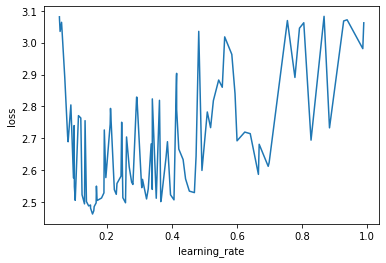

In [111]:
loss_plot('learning_rate', TRIALS)

## Train a final model
Increasing the number of boosters by increasing n_estimators

In [112]:

default_params = {"n_estimators":500,
                  "verbose_eval":1,
                  "random_state":1}

best_params.update(default_params)

ngb = NGBRegressor(**best_params).fit(X_train,y_train,X_val=X_validation, Y_val=y_validation, early_stopping_rounds=2)

[iter 0] loss=3.5985 val_loss=3.4948 scale=0.5000 norm=3.2975
[iter 1] loss=3.4531 val_loss=3.4221 scale=0.5000 norm=3.0734
[iter 2] loss=3.3794 val_loss=3.3681 scale=0.5000 norm=2.8746
[iter 3] loss=3.3228 val_loss=3.2816 scale=1.0000 norm=5.3756
[iter 4] loss=3.2270 val_loss=3.2027 scale=1.0000 norm=4.7141
[iter 5] loss=3.1446 val_loss=3.1334 scale=1.0000 norm=4.1647
[iter 6] loss=3.0705 val_loss=3.0678 scale=1.0000 norm=3.7306
[iter 7] loss=2.9973 val_loss=3.0080 scale=1.0000 norm=3.3311
[iter 8] loss=2.9277 val_loss=2.8873 scale=2.0000 norm=6.0302
[iter 9] loss=2.7898 val_loss=2.7795 scale=2.0000 norm=4.9418
[iter 10] loss=2.6611 val_loss=2.6833 scale=2.0000 norm=4.2073
[iter 11] loss=2.5355 val_loss=2.6045 scale=2.0000 norm=3.7010
[iter 12] loss=2.4163 val_loss=2.5368 scale=2.0000 norm=3.3475
[iter 13] loss=2.2961 val_loss=2.5018 scale=2.0000 norm=3.0308
[iter 14] loss=2.1843 val_loss=2.4809 scale=2.0000 norm=2.8158
[iter 15] loss=2.0761 val_loss=2.5031 scale=2.0000 norm=2.6349
==

## Evaluate on a test set

In [113]:
Y_pred = ngb.predict(X_test)
Y_dist = ngb.pred_dist(X_test)

In [114]:
Mae = median_absolute_error(y_test, Y_pred)
logger.info(f"Median Absolute Error = {Mae}")

mea = mean_absolute_error(y_test, Y_pred)
logger.info(f"Mean Absolute Error = {mea}")

2020-07-15 09:27:34 INFO     Median Absolute Error = 1.9598622635748058
2020-07-15 09:27:34 INFO     Mean Absolute Error = 2.3571482250981703


Text(336.9714285714286, 0.5, 'Predictions [Hours]')

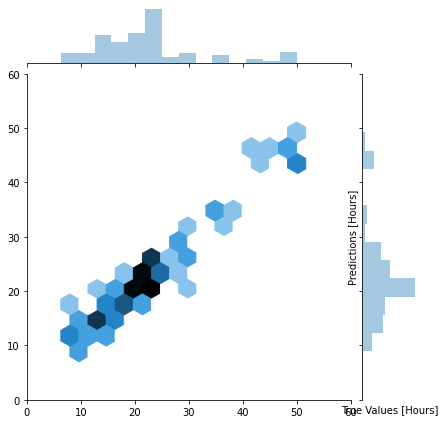

In [116]:
samp_low = 0
samp_high = 60

# a = plt.axes(aspect="equal")
sns.jointplot(y_test[(y_test > samp_low) & (y_test < samp_high)], Y_pred[(y_test > samp_low) & (y_test < samp_high)], kind="hexbin", bins="log", xlim=(samp_low,samp_high), ylim=(samp_low, samp_high))
# plt.scatter(y_samp, y_pred)
plt.xlabel("True Values [Hours]")
plt.ylabel("Predictions [Hours]")